In [1]:
import numpy as np
import tensorflow as tf
#from tensorflow.keras.models import Model
#from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.optimizers import Adam

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


2023-11-24 14:48:25.425380: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import os
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
#from u_interpolate_small import regrid_irregular_quick
from datetime import date
import u_interpolate_small as uint
from ndays import numOfDays
import glob
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cf
import pickle 
import calendar

In [3]:
# Define domain and time period
start_lat = 12 # 5 
end_lat = 17 #10
start_lon = -17 #-10
end_lon = -12 #0
start_year = '2010'
start_month = '05'
end_year = '2010'
end_month = '10'
start_day = '01'
end_day = '31'

# find ndays
date1 = date(int(start_year), int(start_month), int(start_day))
date2 = date(int(end_year), int(end_month), int(end_day))
t = numOfDays(date1, date2)+1

# define a regular lat/lon grid close to MSG native resolution (0.04 deg)
#reg_lat = np.arange(start_lat, end_lat, 0.04)
#reg_lon = np.arange(start_lon, end_lon, 0.04) 

In [4]:
# get native MSG grid (core)
coords_filename= './nxny1640_580_nxnyds164580_blobdx0.04491576_area4_n23_20_32.nc'#[0]  # this is /prj/Africa_cloud/geoloc/*.npz on the Linux system
msg_file = xr.open_dataset(coords_filename).squeeze() # pick any convective core file from ch9_wavelet. 
mlon = msg_file['lons_mid'].values
mlat = msg_file['lats_mid'].values


In [5]:
# find core indices using one file
lat_ind = np.where((mlat[:,1]>=start_lat) & (mlat[:,1]<=end_lat))[0]
lon_ind = np.where((mlon[1,:]>=start_lon) & (mlon[1,:]<=end_lon))[0]
lat = mlat[lat_ind[0]:lat_ind[-1]+1,lon_ind[0]:lon_ind[-1]+1]
lon = mlon[lat_ind[0]:lat_ind[-1]+1,lon_ind[0]:lon_ind[-1]+1]
#lon = lon_fl[(lon_fl>= start_lon) & (lon_fl<=end_lon)]
#X, Y = np.meshgrid(lon,lat)

cores = np.zeros((t*96,len(lat[:,1]),len(lon[1,:])),dtype=float) #using every fourth value for hourly comparison- 24hr
tir = np.zeros((t*96,len(lat[:,1]),len(lon[1,:])),dtype=float) #using every fourth value for hourly comparison- 24hr
time_core = np.zeros((t*96)) #using every fourth value for hourly comparison- 24hr

In [6]:
# read in input data- TIR and historical core data at t<to
#core_filename= '/prj/nflics/hist_cores/2008/06/01/Hist_cores_wa_200806011045.nc'
#ds = xr.open_dataset(core_filename).squeeze() # pick any convective core file from ch9_wavelet. 
#cores = ds['msg_cores'].values# uint.interpolate_data(ds['cores'].values, inds, weights, shape) # interpolation using saved weights for MSG cores       
#tir = ds['msg_Tir'].values/10000 # uint.interpolate_data(ds['tir'].values, inds, weights, shape)  # interpolation using saved weights for MSG TIR          
#time_core = ds['time']# (core_filename[-15:-3])


In [7]:
# read in cores data
list_of_file_names = []

if int(start_year)==int(end_year): 
    for m in range(int(start_month),int(end_month)+1,1): # 1 to include the end month
        if m<10:
            month = str(m).zfill(2)
        else:
            month = str(m)  
        for d in range(1,calendar.monthrange(int(start_year), m)[1]+1,1): # 1 to include the end month
            if d<10:
                day = str(d).zfill(2)
            else:
                day = str(d)  
            #core_filename= '/prj/nflics/hist_cores/2008/06/01/Hist_cores_wa_200806011045.nc'
            dir_name = '/prj/nflics/hist_cores/'+start_year+'/'+month+'/'+day+'/'
            all_file_names=sorted(glob.glob(dir_name+"Hist_cores_wa_*.nc"));
            list_of_file_names.append(all_file_names) # all days in month
        #if os.path.isfile(all_file_names):      
         #   list_of_file_names.append(all_file_names) # all days in month
        #else:
         #   list_of_file_names.append('file_not_available') # all days in month
            #print(all_file_names)
             
elif int(start_year)<int(end_year):
    y=1
    for i in range(int(start_year),int(end_year)+1,1):
        if y==1:
            for m in range(int(start_month),10,1):
                if m<10:
                    month = str(m).zfill(2)
                else:
                    month = str(m)  
                for d in range(1,calendar.monthrange(i, m)[1]+1,1):
                #for d in range(1,30,1): # 1 to include the end month
                    if d<10:
                        day = str(d).zfill(2)
                    else:
                        day = str(d)  
            #core_filename= '/prj/nflics/hist_cores/2008/06/01/Hist_cores_wa_200806011045.nc'
                    dir_name = '/prj/nflics/hist_cores/'+start_year+'/'+month+'/'+day+'/'
                    all_file_names=sorted(glob.glob(dir_name+"Hist_cores_wa_*.nc"));
                    list_of_file_names.append(all_file_names) # all days in month
            #print((all_file_names))
                #print(len(all_file_names))
                y=y+1
                month=[]
            
        else:
            for m in range(1,int(end_month)+1,1):
                if m<10:
                    month = str(m).zfill(2)
                else:
                    month = str(m)    
                for d in range(1,calendar.monthrange(i, m)[1]+1,1):
                    if d<10:
                        day = str(d).zfill(2)
                    else:
                        day = str(d)  
                    dir_name = '/prj/nflics/hist_cores/'+start_year+'/'+month+'/'+day+'/'
                    all_file_names=sorted(glob.glob(dir_name+"Hist_cores_wa_*.nc"));
                    list_of_file_names.append(all_file_names) # all days in month
                  
list_of_files=[]                
for a in range(0,len(list_of_file_names),1):
    list_of_files = list_of_files+list_of_file_names[a]
#if int(start_year)<int(end_year):
 #   list_of_files = list_of_files[0]+list_of_files[1]
#else:
   # list_of_files = list_of_files[0]#+list_of_files[1]    
print(len(list_of_files))

11712


In [8]:
for l in range(0,len(list_of_files),1):#, min(t*96,len(list_of_files)), 4):#range(len(list_of_files)): # 96 files per day
    core_filename = list_of_files[l]#'/prj/Africa_cloud/ch9_wavelet/'+str(i)+'/'+month+'/'  list_of_files[l]
    print(core_filename)
    #if os.path.isfile(all_file_names):      
    ds = xr.open_dataset(core_filename).squeeze() 
    print(l)
    core_temp = ds['msg_cores'].values
    cores[l,:,:] = core_temp[lat_ind[0]:lat_ind[-1]+1,lon_ind[0]:lon_ind[-1]+1]
    #uint.interpolate_data(ds['cores'].values, inds, weights, shape) # interpolation using saved weights for MSG cores       
    tir_temp =  ds['msg_Tir'].values/10000
    tir[l,:,:] = tir_temp[lat_ind[0]:lat_ind[-1]+1,lon_ind[0]:lon_ind[-1]+1]    
    time_core[l] = str(core_filename[-15:-3])
    #else:
     #   cores[:,:,l] = cores_temp*np.nan  
      #  tir[:,:,l] = tir_temp*np.nan   
       # time_core[l] = (core_filename[-15:-3])
  

/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010000.nc
0
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010015.nc
1
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010030.nc
2
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010045.nc
3
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010100.nc
4
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010115.nc
5
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010130.nc
6
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010145.nc
7
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010200.nc
8
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010215.nc
9
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010230.nc
10
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010245.nc
11
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010300.nc
12
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010315.nc
13
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010330.nc
14
/prj/

122
/prj/nflics/hist_cores/2010/06/02/Hist_cores_wa_201006020645.nc
123
/prj/nflics/hist_cores/2010/06/02/Hist_cores_wa_201006020700.nc
124
/prj/nflics/hist_cores/2010/06/02/Hist_cores_wa_201006020715.nc
125
/prj/nflics/hist_cores/2010/06/02/Hist_cores_wa_201006020730.nc
126
/prj/nflics/hist_cores/2010/06/02/Hist_cores_wa_201006020745.nc
127
/prj/nflics/hist_cores/2010/06/02/Hist_cores_wa_201006020800.nc
128
/prj/nflics/hist_cores/2010/06/02/Hist_cores_wa_201006020815.nc
129
/prj/nflics/hist_cores/2010/06/02/Hist_cores_wa_201006020830.nc
130
/prj/nflics/hist_cores/2010/06/02/Hist_cores_wa_201006020845.nc
131
/prj/nflics/hist_cores/2010/06/02/Hist_cores_wa_201006020900.nc
132
/prj/nflics/hist_cores/2010/06/02/Hist_cores_wa_201006020915.nc
133
/prj/nflics/hist_cores/2010/06/02/Hist_cores_wa_201006020930.nc
134
/prj/nflics/hist_cores/2010/06/02/Hist_cores_wa_201006020945.nc
135
/prj/nflics/hist_cores/2010/06/02/Hist_cores_wa_201006021000.nc
136
/prj/nflics/hist_cores/2010/06/02/Hist_cores

243
/prj/nflics/hist_cores/2010/06/03/Hist_cores_wa_201006031300.nc
244
/prj/nflics/hist_cores/2010/06/03/Hist_cores_wa_201006031315.nc
245
/prj/nflics/hist_cores/2010/06/03/Hist_cores_wa_201006031330.nc
246
/prj/nflics/hist_cores/2010/06/03/Hist_cores_wa_201006031345.nc
247
/prj/nflics/hist_cores/2010/06/03/Hist_cores_wa_201006031400.nc
248
/prj/nflics/hist_cores/2010/06/03/Hist_cores_wa_201006031415.nc
249
/prj/nflics/hist_cores/2010/06/03/Hist_cores_wa_201006031430.nc
250
/prj/nflics/hist_cores/2010/06/03/Hist_cores_wa_201006031445.nc
251
/prj/nflics/hist_cores/2010/06/03/Hist_cores_wa_201006031500.nc
252
/prj/nflics/hist_cores/2010/06/03/Hist_cores_wa_201006031515.nc
253
/prj/nflics/hist_cores/2010/06/03/Hist_cores_wa_201006031530.nc
254
/prj/nflics/hist_cores/2010/06/03/Hist_cores_wa_201006031545.nc
255
/prj/nflics/hist_cores/2010/06/03/Hist_cores_wa_201006031600.nc
256
/prj/nflics/hist_cores/2010/06/03/Hist_cores_wa_201006031615.nc
257
/prj/nflics/hist_cores/2010/06/03/Hist_cores

364
/prj/nflics/hist_cores/2010/06/04/Hist_cores_wa_201006041915.nc
365
/prj/nflics/hist_cores/2010/06/04/Hist_cores_wa_201006041930.nc
366
/prj/nflics/hist_cores/2010/06/04/Hist_cores_wa_201006041945.nc
367
/prj/nflics/hist_cores/2010/06/04/Hist_cores_wa_201006042000.nc
368
/prj/nflics/hist_cores/2010/06/04/Hist_cores_wa_201006042015.nc
369
/prj/nflics/hist_cores/2010/06/04/Hist_cores_wa_201006042030.nc
370
/prj/nflics/hist_cores/2010/06/04/Hist_cores_wa_201006042045.nc
371
/prj/nflics/hist_cores/2010/06/04/Hist_cores_wa_201006042100.nc
372
/prj/nflics/hist_cores/2010/06/04/Hist_cores_wa_201006042115.nc
373
/prj/nflics/hist_cores/2010/06/04/Hist_cores_wa_201006042130.nc
374
/prj/nflics/hist_cores/2010/06/04/Hist_cores_wa_201006042145.nc
375
/prj/nflics/hist_cores/2010/06/04/Hist_cores_wa_201006042200.nc
376
/prj/nflics/hist_cores/2010/06/04/Hist_cores_wa_201006042215.nc
377
/prj/nflics/hist_cores/2010/06/04/Hist_cores_wa_201006042230.nc
378
/prj/nflics/hist_cores/2010/06/04/Hist_cores

/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060130.nc
486
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060145.nc
487
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060200.nc
488
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060215.nc
489
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060230.nc
490
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060245.nc
491
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060300.nc
492
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060315.nc
493
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060330.nc
494
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060345.nc
495
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060400.nc
496
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060415.nc
497
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060430.nc
498
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060445.nc
499
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_

606
/prj/nflics/hist_cores/2010/06/07/Hist_cores_wa_201006070745.nc
607
/prj/nflics/hist_cores/2010/06/07/Hist_cores_wa_201006070800.nc
608
/prj/nflics/hist_cores/2010/06/07/Hist_cores_wa_201006070815.nc
609
/prj/nflics/hist_cores/2010/06/07/Hist_cores_wa_201006070830.nc
610
/prj/nflics/hist_cores/2010/06/07/Hist_cores_wa_201006070845.nc
611
/prj/nflics/hist_cores/2010/06/07/Hist_cores_wa_201006070900.nc
612
/prj/nflics/hist_cores/2010/06/07/Hist_cores_wa_201006070915.nc
613
/prj/nflics/hist_cores/2010/06/07/Hist_cores_wa_201006070930.nc
614
/prj/nflics/hist_cores/2010/06/07/Hist_cores_wa_201006070945.nc
615
/prj/nflics/hist_cores/2010/06/07/Hist_cores_wa_201006071000.nc
616
/prj/nflics/hist_cores/2010/06/07/Hist_cores_wa_201006071015.nc
617
/prj/nflics/hist_cores/2010/06/07/Hist_cores_wa_201006071030.nc
618
/prj/nflics/hist_cores/2010/06/07/Hist_cores_wa_201006071045.nc
619
/prj/nflics/hist_cores/2010/06/07/Hist_cores_wa_201006071100.nc
620
/prj/nflics/hist_cores/2010/06/07/Hist_cores

727
/prj/nflics/hist_cores/2010/06/08/Hist_cores_wa_201006081400.nc
728
/prj/nflics/hist_cores/2010/06/08/Hist_cores_wa_201006081415.nc
729
/prj/nflics/hist_cores/2010/06/08/Hist_cores_wa_201006081430.nc
730
/prj/nflics/hist_cores/2010/06/08/Hist_cores_wa_201006081445.nc
731
/prj/nflics/hist_cores/2010/06/08/Hist_cores_wa_201006081500.nc
732
/prj/nflics/hist_cores/2010/06/08/Hist_cores_wa_201006081515.nc
733
/prj/nflics/hist_cores/2010/06/08/Hist_cores_wa_201006081530.nc
734
/prj/nflics/hist_cores/2010/06/08/Hist_cores_wa_201006081545.nc
735
/prj/nflics/hist_cores/2010/06/08/Hist_cores_wa_201006081600.nc
736
/prj/nflics/hist_cores/2010/06/08/Hist_cores_wa_201006081615.nc
737
/prj/nflics/hist_cores/2010/06/08/Hist_cores_wa_201006081630.nc
738
/prj/nflics/hist_cores/2010/06/08/Hist_cores_wa_201006081645.nc
739
/prj/nflics/hist_cores/2010/06/08/Hist_cores_wa_201006081700.nc
740
/prj/nflics/hist_cores/2010/06/08/Hist_cores_wa_201006081715.nc
741
/prj/nflics/hist_cores/2010/06/08/Hist_cores

849
/prj/nflics/hist_cores/2010/06/09/Hist_cores_wa_201006092030.nc
850
/prj/nflics/hist_cores/2010/06/09/Hist_cores_wa_201006092045.nc
851
/prj/nflics/hist_cores/2010/06/09/Hist_cores_wa_201006092100.nc
852
/prj/nflics/hist_cores/2010/06/09/Hist_cores_wa_201006092115.nc
853
/prj/nflics/hist_cores/2010/06/09/Hist_cores_wa_201006092130.nc
854
/prj/nflics/hist_cores/2010/06/09/Hist_cores_wa_201006092145.nc
855
/prj/nflics/hist_cores/2010/06/09/Hist_cores_wa_201006092200.nc
856
/prj/nflics/hist_cores/2010/06/09/Hist_cores_wa_201006092215.nc
857
/prj/nflics/hist_cores/2010/06/09/Hist_cores_wa_201006092230.nc
858
/prj/nflics/hist_cores/2010/06/09/Hist_cores_wa_201006092245.nc
859
/prj/nflics/hist_cores/2010/06/09/Hist_cores_wa_201006092300.nc
860
/prj/nflics/hist_cores/2010/06/09/Hist_cores_wa_201006092315.nc
861
/prj/nflics/hist_cores/2010/06/09/Hist_cores_wa_201006092330.nc
862
/prj/nflics/hist_cores/2010/06/09/Hist_cores_wa_201006092345.nc
863
/prj/nflics/hist_cores/2010/06/10/Hist_cores

/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110245.nc
971
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110300.nc
972
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110315.nc
973
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110330.nc
974
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110345.nc
975
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110400.nc
976
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110415.nc
977
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110430.nc
978
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110445.nc
979
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110500.nc
980
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110515.nc
981
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110530.nc
982
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110545.nc
983
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110600.nc
984
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_

1090
/prj/nflics/hist_cores/2010/06/12/Hist_cores_wa_201006120845.nc
1091
/prj/nflics/hist_cores/2010/06/12/Hist_cores_wa_201006120900.nc
1092
/prj/nflics/hist_cores/2010/06/12/Hist_cores_wa_201006120915.nc
1093
/prj/nflics/hist_cores/2010/06/12/Hist_cores_wa_201006120930.nc
1094
/prj/nflics/hist_cores/2010/06/12/Hist_cores_wa_201006120945.nc
1095
/prj/nflics/hist_cores/2010/06/12/Hist_cores_wa_201006121000.nc
1096
/prj/nflics/hist_cores/2010/06/12/Hist_cores_wa_201006121015.nc
1097
/prj/nflics/hist_cores/2010/06/12/Hist_cores_wa_201006121030.nc
1098
/prj/nflics/hist_cores/2010/06/12/Hist_cores_wa_201006121045.nc
1099
/prj/nflics/hist_cores/2010/06/12/Hist_cores_wa_201006121100.nc
1100
/prj/nflics/hist_cores/2010/06/12/Hist_cores_wa_201006121115.nc
1101
/prj/nflics/hist_cores/2010/06/12/Hist_cores_wa_201006121130.nc
1102
/prj/nflics/hist_cores/2010/06/12/Hist_cores_wa_201006121145.nc
1103
/prj/nflics/hist_cores/2010/06/12/Hist_cores_wa_201006121200.nc
1104
/prj/nflics/hist_cores/2010/0

1211
/prj/nflics/hist_cores/2010/06/13/Hist_cores_wa_201006131500.nc
1212
/prj/nflics/hist_cores/2010/06/13/Hist_cores_wa_201006131515.nc
1213
/prj/nflics/hist_cores/2010/06/13/Hist_cores_wa_201006131530.nc
1214
/prj/nflics/hist_cores/2010/06/13/Hist_cores_wa_201006131545.nc
1215
/prj/nflics/hist_cores/2010/06/13/Hist_cores_wa_201006131600.nc
1216
/prj/nflics/hist_cores/2010/06/13/Hist_cores_wa_201006131615.nc
1217
/prj/nflics/hist_cores/2010/06/13/Hist_cores_wa_201006131630.nc
1218
/prj/nflics/hist_cores/2010/06/13/Hist_cores_wa_201006131645.nc
1219
/prj/nflics/hist_cores/2010/06/13/Hist_cores_wa_201006131700.nc
1220
/prj/nflics/hist_cores/2010/06/13/Hist_cores_wa_201006131715.nc
1221
/prj/nflics/hist_cores/2010/06/13/Hist_cores_wa_201006131730.nc
1222
/prj/nflics/hist_cores/2010/06/13/Hist_cores_wa_201006131745.nc
1223
/prj/nflics/hist_cores/2010/06/13/Hist_cores_wa_201006131800.nc
1224
/prj/nflics/hist_cores/2010/06/13/Hist_cores_wa_201006131815.nc
1225
/prj/nflics/hist_cores/2010/0

1331
/prj/nflics/hist_cores/2010/06/14/Hist_cores_wa_201006142100.nc
1332
/prj/nflics/hist_cores/2010/06/14/Hist_cores_wa_201006142115.nc
1333
/prj/nflics/hist_cores/2010/06/14/Hist_cores_wa_201006142130.nc
1334
/prj/nflics/hist_cores/2010/06/14/Hist_cores_wa_201006142145.nc
1335
/prj/nflics/hist_cores/2010/06/14/Hist_cores_wa_201006142200.nc
1336
/prj/nflics/hist_cores/2010/06/14/Hist_cores_wa_201006142215.nc
1337
/prj/nflics/hist_cores/2010/06/14/Hist_cores_wa_201006142230.nc
1338
/prj/nflics/hist_cores/2010/06/14/Hist_cores_wa_201006142245.nc
1339
/prj/nflics/hist_cores/2010/06/14/Hist_cores_wa_201006142300.nc
1340
/prj/nflics/hist_cores/2010/06/14/Hist_cores_wa_201006142315.nc
1341
/prj/nflics/hist_cores/2010/06/14/Hist_cores_wa_201006142330.nc
1342
/prj/nflics/hist_cores/2010/06/14/Hist_cores_wa_201006142345.nc
1343
/prj/nflics/hist_cores/2010/06/15/Hist_cores_wa_201006150000.nc
1344
/prj/nflics/hist_cores/2010/06/15/Hist_cores_wa_201006150015.nc
1345
/prj/nflics/hist_cores/2010/0

1450
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006160245.nc
1451
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006160300.nc
1452
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006160315.nc
1453
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006160330.nc
1454
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006160345.nc
1455
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006160400.nc
1456
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006160415.nc
1457
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006160430.nc
1458
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006160445.nc
1459
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006160500.nc
1460
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006160515.nc
1461
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006160530.nc
1462
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006160545.nc
1463
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006160600.nc
1464
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/06/17/Hist_cores_wa_201006170830.nc
1570
/prj/nflics/hist_cores/2010/06/17/Hist_cores_wa_201006170845.nc
1571
/prj/nflics/hist_cores/2010/06/17/Hist_cores_wa_201006170900.nc
1572
/prj/nflics/hist_cores/2010/06/17/Hist_cores_wa_201006170915.nc
1573
/prj/nflics/hist_cores/2010/06/17/Hist_cores_wa_201006170930.nc
1574
/prj/nflics/hist_cores/2010/06/17/Hist_cores_wa_201006170945.nc
1575
/prj/nflics/hist_cores/2010/06/17/Hist_cores_wa_201006171000.nc
1576
/prj/nflics/hist_cores/2010/06/17/Hist_cores_wa_201006171015.nc
1577
/prj/nflics/hist_cores/2010/06/17/Hist_cores_wa_201006171030.nc
1578
/prj/nflics/hist_cores/2010/06/17/Hist_cores_wa_201006171045.nc
1579
/prj/nflics/hist_cores/2010/06/17/Hist_cores_wa_201006171100.nc
1580
/prj/nflics/hist_cores/2010/06/17/Hist_cores_wa_201006171115.nc
1581
/prj/nflics/hist_cores/2010/06/17/Hist_cores_wa_201006171130.nc
1582
/prj/nflics/hist_cores/2010/06/17/Hist_cores_wa_201006171145.nc
1583
/prj/nflics/hist_cores/2010/06/17/

1689
/prj/nflics/hist_cores/2010/06/18/Hist_cores_wa_201006181430.nc
1690
/prj/nflics/hist_cores/2010/06/18/Hist_cores_wa_201006181445.nc
1691
/prj/nflics/hist_cores/2010/06/18/Hist_cores_wa_201006181500.nc
1692
/prj/nflics/hist_cores/2010/06/18/Hist_cores_wa_201006181515.nc
1693
/prj/nflics/hist_cores/2010/06/18/Hist_cores_wa_201006181530.nc
1694
/prj/nflics/hist_cores/2010/06/18/Hist_cores_wa_201006181545.nc
1695
/prj/nflics/hist_cores/2010/06/18/Hist_cores_wa_201006181600.nc
1696
/prj/nflics/hist_cores/2010/06/18/Hist_cores_wa_201006181615.nc
1697
/prj/nflics/hist_cores/2010/06/18/Hist_cores_wa_201006181630.nc
1698
/prj/nflics/hist_cores/2010/06/18/Hist_cores_wa_201006181645.nc
1699
/prj/nflics/hist_cores/2010/06/18/Hist_cores_wa_201006181700.nc
1700
/prj/nflics/hist_cores/2010/06/18/Hist_cores_wa_201006181715.nc
1701
/prj/nflics/hist_cores/2010/06/18/Hist_cores_wa_201006181730.nc
1702
/prj/nflics/hist_cores/2010/06/18/Hist_cores_wa_201006181745.nc
1703
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/06/19/Hist_cores_wa_201006192030.nc
1810
/prj/nflics/hist_cores/2010/06/19/Hist_cores_wa_201006192045.nc
1811
/prj/nflics/hist_cores/2010/06/19/Hist_cores_wa_201006192100.nc
1812
/prj/nflics/hist_cores/2010/06/19/Hist_cores_wa_201006192115.nc
1813
/prj/nflics/hist_cores/2010/06/19/Hist_cores_wa_201006192130.nc
1814
/prj/nflics/hist_cores/2010/06/19/Hist_cores_wa_201006192145.nc
1815
/prj/nflics/hist_cores/2010/06/19/Hist_cores_wa_201006192200.nc
1816
/prj/nflics/hist_cores/2010/06/19/Hist_cores_wa_201006192215.nc
1817
/prj/nflics/hist_cores/2010/06/19/Hist_cores_wa_201006192230.nc
1818
/prj/nflics/hist_cores/2010/06/19/Hist_cores_wa_201006192245.nc
1819
/prj/nflics/hist_cores/2010/06/19/Hist_cores_wa_201006192300.nc
1820
/prj/nflics/hist_cores/2010/06/19/Hist_cores_wa_201006192315.nc
1821
/prj/nflics/hist_cores/2010/06/19/Hist_cores_wa_201006192330.nc
1822
/prj/nflics/hist_cores/2010/06/19/Hist_cores_wa_201006192345.nc
1823
/prj/nflics/hist_cores/2010/06/20/

1928
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006210215.nc
1929
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006210230.nc
1930
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006210245.nc
1931
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006210300.nc
1932
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006210315.nc
1933
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006210330.nc
1934
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006210345.nc
1935
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006210400.nc
1936
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006210415.nc
1937
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006210430.nc
1938
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006210445.nc
1939
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006210500.nc
1940
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006210515.nc
1941
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006210530.nc
1942
/prj/nflics/hist_cores/2010/0

2047
/prj/nflics/hist_cores/2010/06/22/Hist_cores_wa_201006220800.nc
2048
/prj/nflics/hist_cores/2010/06/22/Hist_cores_wa_201006220815.nc
2049
/prj/nflics/hist_cores/2010/06/22/Hist_cores_wa_201006220830.nc
2050
/prj/nflics/hist_cores/2010/06/22/Hist_cores_wa_201006220845.nc
2051
/prj/nflics/hist_cores/2010/06/22/Hist_cores_wa_201006220900.nc
2052
/prj/nflics/hist_cores/2010/06/22/Hist_cores_wa_201006220915.nc
2053
/prj/nflics/hist_cores/2010/06/22/Hist_cores_wa_201006220930.nc
2054
/prj/nflics/hist_cores/2010/06/22/Hist_cores_wa_201006220945.nc
2055
/prj/nflics/hist_cores/2010/06/22/Hist_cores_wa_201006221000.nc
2056
/prj/nflics/hist_cores/2010/06/22/Hist_cores_wa_201006221015.nc
2057
/prj/nflics/hist_cores/2010/06/22/Hist_cores_wa_201006221030.nc
2058
/prj/nflics/hist_cores/2010/06/22/Hist_cores_wa_201006221045.nc
2059
/prj/nflics/hist_cores/2010/06/22/Hist_cores_wa_201006221100.nc
2060
/prj/nflics/hist_cores/2010/06/22/Hist_cores_wa_201006221115.nc
2061
/prj/nflics/hist_cores/2010/0

2166
/prj/nflics/hist_cores/2010/06/23/Hist_cores_wa_201006231345.nc
2167
/prj/nflics/hist_cores/2010/06/23/Hist_cores_wa_201006231400.nc
2168
/prj/nflics/hist_cores/2010/06/23/Hist_cores_wa_201006231415.nc
2169
/prj/nflics/hist_cores/2010/06/23/Hist_cores_wa_201006231430.nc
2170
/prj/nflics/hist_cores/2010/06/23/Hist_cores_wa_201006231445.nc
2171
/prj/nflics/hist_cores/2010/06/23/Hist_cores_wa_201006231500.nc
2172
/prj/nflics/hist_cores/2010/06/23/Hist_cores_wa_201006231515.nc
2173
/prj/nflics/hist_cores/2010/06/23/Hist_cores_wa_201006231530.nc
2174
/prj/nflics/hist_cores/2010/06/23/Hist_cores_wa_201006231545.nc
2175
/prj/nflics/hist_cores/2010/06/23/Hist_cores_wa_201006231600.nc
2176
/prj/nflics/hist_cores/2010/06/23/Hist_cores_wa_201006231615.nc
2177
/prj/nflics/hist_cores/2010/06/23/Hist_cores_wa_201006231630.nc
2178
/prj/nflics/hist_cores/2010/06/23/Hist_cores_wa_201006231645.nc
2179
/prj/nflics/hist_cores/2010/06/23/Hist_cores_wa_201006231700.nc
2180
/prj/nflics/hist_cores/2010/0

2286
/prj/nflics/hist_cores/2010/06/24/Hist_cores_wa_201006241945.nc
2287
/prj/nflics/hist_cores/2010/06/24/Hist_cores_wa_201006242000.nc
2288
/prj/nflics/hist_cores/2010/06/24/Hist_cores_wa_201006242015.nc
2289
/prj/nflics/hist_cores/2010/06/24/Hist_cores_wa_201006242030.nc
2290
/prj/nflics/hist_cores/2010/06/24/Hist_cores_wa_201006242045.nc
2291
/prj/nflics/hist_cores/2010/06/24/Hist_cores_wa_201006242100.nc
2292
/prj/nflics/hist_cores/2010/06/24/Hist_cores_wa_201006242115.nc
2293
/prj/nflics/hist_cores/2010/06/24/Hist_cores_wa_201006242130.nc
2294
/prj/nflics/hist_cores/2010/06/24/Hist_cores_wa_201006242145.nc
2295
/prj/nflics/hist_cores/2010/06/24/Hist_cores_wa_201006242200.nc
2296
/prj/nflics/hist_cores/2010/06/24/Hist_cores_wa_201006242215.nc
2297
/prj/nflics/hist_cores/2010/06/24/Hist_cores_wa_201006242230.nc
2298
/prj/nflics/hist_cores/2010/06/24/Hist_cores_wa_201006242245.nc
2299
/prj/nflics/hist_cores/2010/06/24/Hist_cores_wa_201006242300.nc
2300
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006260130.nc
2406
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006260145.nc
2407
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006260200.nc
2408
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006260215.nc
2409
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006260230.nc
2410
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006260245.nc
2411
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006260300.nc
2412
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006260315.nc
2413
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006260330.nc
2414
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006260345.nc
2415
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006260400.nc
2416
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006260415.nc
2417
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006260430.nc
2418
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006260445.nc
2419
/prj/nflics/hist_cores/2010/06/26/

/prj/nflics/hist_cores/2010/06/27/Hist_cores_wa_201006270715.nc
2525
/prj/nflics/hist_cores/2010/06/27/Hist_cores_wa_201006270730.nc
2526
/prj/nflics/hist_cores/2010/06/27/Hist_cores_wa_201006270745.nc
2527
/prj/nflics/hist_cores/2010/06/27/Hist_cores_wa_201006270800.nc
2528
/prj/nflics/hist_cores/2010/06/27/Hist_cores_wa_201006270815.nc
2529
/prj/nflics/hist_cores/2010/06/27/Hist_cores_wa_201006270830.nc
2530
/prj/nflics/hist_cores/2010/06/27/Hist_cores_wa_201006270845.nc
2531
/prj/nflics/hist_cores/2010/06/27/Hist_cores_wa_201006270900.nc
2532
/prj/nflics/hist_cores/2010/06/27/Hist_cores_wa_201006270915.nc
2533
/prj/nflics/hist_cores/2010/06/27/Hist_cores_wa_201006270930.nc
2534
/prj/nflics/hist_cores/2010/06/27/Hist_cores_wa_201006270945.nc
2535
/prj/nflics/hist_cores/2010/06/27/Hist_cores_wa_201006271000.nc
2536
/prj/nflics/hist_cores/2010/06/27/Hist_cores_wa_201006271015.nc
2537
/prj/nflics/hist_cores/2010/06/27/Hist_cores_wa_201006271030.nc
2538
/prj/nflics/hist_cores/2010/06/27/

/prj/nflics/hist_cores/2010/06/28/Hist_cores_wa_201006281315.nc
2645
/prj/nflics/hist_cores/2010/06/28/Hist_cores_wa_201006281330.nc
2646
/prj/nflics/hist_cores/2010/06/28/Hist_cores_wa_201006281345.nc
2647
/prj/nflics/hist_cores/2010/06/28/Hist_cores_wa_201006281400.nc
2648
/prj/nflics/hist_cores/2010/06/28/Hist_cores_wa_201006281415.nc
2649
/prj/nflics/hist_cores/2010/06/28/Hist_cores_wa_201006281430.nc
2650
/prj/nflics/hist_cores/2010/06/28/Hist_cores_wa_201006281445.nc
2651
/prj/nflics/hist_cores/2010/06/28/Hist_cores_wa_201006281500.nc
2652
/prj/nflics/hist_cores/2010/06/28/Hist_cores_wa_201006281515.nc
2653
/prj/nflics/hist_cores/2010/06/28/Hist_cores_wa_201006281530.nc
2654
/prj/nflics/hist_cores/2010/06/28/Hist_cores_wa_201006281545.nc
2655
/prj/nflics/hist_cores/2010/06/28/Hist_cores_wa_201006281600.nc
2656
/prj/nflics/hist_cores/2010/06/28/Hist_cores_wa_201006281615.nc
2657
/prj/nflics/hist_cores/2010/06/28/Hist_cores_wa_201006281630.nc
2658
/prj/nflics/hist_cores/2010/06/28/

/prj/nflics/hist_cores/2010/06/29/Hist_cores_wa_201006291930.nc
2766
/prj/nflics/hist_cores/2010/06/29/Hist_cores_wa_201006291945.nc
2767
/prj/nflics/hist_cores/2010/06/29/Hist_cores_wa_201006292000.nc
2768
/prj/nflics/hist_cores/2010/06/29/Hist_cores_wa_201006292015.nc
2769
/prj/nflics/hist_cores/2010/06/29/Hist_cores_wa_201006292030.nc
2770
/prj/nflics/hist_cores/2010/06/29/Hist_cores_wa_201006292045.nc
2771
/prj/nflics/hist_cores/2010/06/29/Hist_cores_wa_201006292100.nc
2772
/prj/nflics/hist_cores/2010/06/29/Hist_cores_wa_201006292115.nc
2773
/prj/nflics/hist_cores/2010/06/29/Hist_cores_wa_201006292130.nc
2774
/prj/nflics/hist_cores/2010/06/29/Hist_cores_wa_201006292145.nc
2775
/prj/nflics/hist_cores/2010/06/29/Hist_cores_wa_201006292200.nc
2776
/prj/nflics/hist_cores/2010/06/29/Hist_cores_wa_201006292215.nc
2777
/prj/nflics/hist_cores/2010/06/29/Hist_cores_wa_201006292230.nc
2778
/prj/nflics/hist_cores/2010/06/29/Hist_cores_wa_201006292245.nc
2779
/prj/nflics/hist_cores/2010/06/29/

2884
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010115.nc
2885
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010130.nc
2886
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010145.nc
2887
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010200.nc
2888
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010215.nc
2889
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010230.nc
2890
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010245.nc
2891
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010300.nc
2892
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010315.nc
2893
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010330.nc
2894
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010345.nc
2895
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010400.nc
2896
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010415.nc
2897
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010430.nc
2898
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007020700.nc
3004
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007020715.nc
3005
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007020730.nc
3006
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007020745.nc
3007
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007020800.nc
3008
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007020815.nc
3009
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007020830.nc
3010
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007020845.nc
3011
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007020900.nc
3012
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007020915.nc
3013
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007020930.nc
3014
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007020945.nc
3015
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007021000.nc
3016
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007021015.nc
3017
/prj/nflics/hist_cores/2010/07/02/

/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031300.nc
3124
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031315.nc
3125
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031330.nc
3126
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031345.nc
3127
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031400.nc
3128
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031415.nc
3129
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031430.nc
3130
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031445.nc
3131
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031500.nc
3132
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031515.nc
3133
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031530.nc
3134
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031545.nc
3135
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031600.nc
3136
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031615.nc
3137
/prj/nflics/hist_cores/2010/07/03/

3242
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007041845.nc
3243
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007041900.nc
3244
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007041915.nc
3245
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007041930.nc
3246
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007041945.nc
3247
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042000.nc
3248
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042015.nc
3249
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042030.nc
3250
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042045.nc
3251
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042100.nc
3252
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042115.nc
3253
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042130.nc
3254
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042145.nc
3255
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042200.nc
3256
/prj/nflics/hist_cores/2010/0

3362
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060045.nc
3363
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060100.nc
3364
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060115.nc
3365
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060130.nc
3366
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060145.nc
3367
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060200.nc
3368
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060215.nc
3369
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060230.nc
3370
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060245.nc
3371
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060300.nc
3372
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060315.nc
3373
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060330.nc
3374
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060345.nc
3375
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060400.nc
3376
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007070645.nc
3483
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007070700.nc
3484
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007070715.nc
3485
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007070730.nc
3486
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007070745.nc
3487
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007070800.nc
3488
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007070815.nc
3489
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007070830.nc
3490
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007070845.nc
3491
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007070900.nc
3492
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007070915.nc
3493
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007070930.nc
3494
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007070945.nc
3495
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007071000.nc
3496
/prj/nflics/hist_cores/2010/07/07/

3601
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081230.nc
3602
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081245.nc
3603
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081300.nc
3604
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081315.nc
3605
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081330.nc
3606
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081345.nc
3607
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081400.nc
3608
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081415.nc
3609
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081430.nc
3610
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081445.nc
3611
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081500.nc
3612
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081515.nc
3613
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081530.nc
3614
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081545.nc
3615
/prj/nflics/hist_cores/2010/0

3720
/prj/nflics/hist_cores/2010/07/09/Hist_cores_wa_201007091815.nc
3721
/prj/nflics/hist_cores/2010/07/09/Hist_cores_wa_201007091830.nc
3722
/prj/nflics/hist_cores/2010/07/09/Hist_cores_wa_201007091845.nc
3723
/prj/nflics/hist_cores/2010/07/09/Hist_cores_wa_201007091900.nc
3724
/prj/nflics/hist_cores/2010/07/09/Hist_cores_wa_201007091915.nc
3725
/prj/nflics/hist_cores/2010/07/09/Hist_cores_wa_201007091930.nc
3726
/prj/nflics/hist_cores/2010/07/09/Hist_cores_wa_201007091945.nc
3727
/prj/nflics/hist_cores/2010/07/09/Hist_cores_wa_201007092000.nc
3728
/prj/nflics/hist_cores/2010/07/09/Hist_cores_wa_201007092015.nc
3729
/prj/nflics/hist_cores/2010/07/09/Hist_cores_wa_201007092030.nc
3730
/prj/nflics/hist_cores/2010/07/09/Hist_cores_wa_201007092045.nc
3731
/prj/nflics/hist_cores/2010/07/09/Hist_cores_wa_201007092100.nc
3732
/prj/nflics/hist_cores/2010/07/09/Hist_cores_wa_201007092115.nc
3733
/prj/nflics/hist_cores/2010/07/09/Hist_cores_wa_201007092130.nc
3734
/prj/nflics/hist_cores/2010/0

3840
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110015.nc
3841
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110030.nc
3842
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110045.nc
3843
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110100.nc
3844
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110115.nc
3845
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110130.nc
3846
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110145.nc
3847
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110200.nc
3848
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110215.nc
3849
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110230.nc
3850
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110245.nc
3851
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110300.nc
3852
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110315.nc
3853
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110330.nc
3854
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007120600.nc
3960
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007120615.nc
3961
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007120630.nc
3962
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007120645.nc
3963
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007120700.nc
3964
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007120715.nc
3965
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007120730.nc
3966
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007120745.nc
3967
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007120800.nc
3968
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007120815.nc
3969
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007120830.nc
3970
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007120845.nc
3971
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007120900.nc
3972
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007120915.nc
3973
/prj/nflics/hist_cores/2010/07/12/

/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131145.nc
4079
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131200.nc
4080
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131215.nc
4081
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131230.nc
4082
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131245.nc
4083
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131300.nc
4084
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131315.nc
4085
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131330.nc
4086
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131345.nc
4087
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131400.nc
4088
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131415.nc
4089
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131430.nc
4090
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131445.nc
4091
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131500.nc
4092
/prj/nflics/hist_cores/2010/07/13/

4198
/prj/nflics/hist_cores/2010/07/14/Hist_cores_wa_201007141745.nc
4199
/prj/nflics/hist_cores/2010/07/14/Hist_cores_wa_201007141800.nc
4200
/prj/nflics/hist_cores/2010/07/14/Hist_cores_wa_201007141815.nc
4201
/prj/nflics/hist_cores/2010/07/14/Hist_cores_wa_201007141830.nc
4202
/prj/nflics/hist_cores/2010/07/14/Hist_cores_wa_201007141845.nc
4203
/prj/nflics/hist_cores/2010/07/14/Hist_cores_wa_201007141900.nc
4204
/prj/nflics/hist_cores/2010/07/14/Hist_cores_wa_201007141915.nc
4205
/prj/nflics/hist_cores/2010/07/14/Hist_cores_wa_201007141930.nc
4206
/prj/nflics/hist_cores/2010/07/14/Hist_cores_wa_201007141945.nc
4207
/prj/nflics/hist_cores/2010/07/14/Hist_cores_wa_201007142000.nc
4208
/prj/nflics/hist_cores/2010/07/14/Hist_cores_wa_201007142015.nc
4209
/prj/nflics/hist_cores/2010/07/14/Hist_cores_wa_201007142030.nc
4210
/prj/nflics/hist_cores/2010/07/14/Hist_cores_wa_201007142045.nc
4211
/prj/nflics/hist_cores/2010/07/14/Hist_cores_wa_201007142100.nc
4212
/prj/nflics/hist_cores/2010/0

4319
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160000.nc
4320
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160015.nc
4321
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160030.nc
4322
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160045.nc
4323
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160100.nc
4324
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160115.nc
4325
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160130.nc
4326
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160145.nc
4327
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160200.nc
4328
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160215.nc
4329
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160230.nc
4330
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160245.nc
4331
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160300.nc
4332
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160315.nc
4333
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007170600.nc
4440
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007170615.nc
4441
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007170630.nc
4442
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007170645.nc
4443
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007170700.nc
4444
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007170715.nc
4445
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007170730.nc
4446
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007170745.nc
4447
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007170800.nc
4448
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007170815.nc
4449
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007170830.nc
4450
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007170845.nc
4451
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007170900.nc
4452
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007170915.nc
4453
/prj/nflics/hist_cores/2010/07/17/

4559
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181200.nc
4560
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181215.nc
4561
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181230.nc
4562
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181245.nc
4563
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181300.nc
4564
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181315.nc
4565
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181330.nc
4566
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181345.nc
4567
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181400.nc
4568
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181415.nc
4569
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181430.nc
4570
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181445.nc
4571
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181500.nc
4572
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181515.nc
4573
/prj/nflics/hist_cores/2010/0

4680
/prj/nflics/hist_cores/2010/07/19/Hist_cores_wa_201007191815.nc
4681
/prj/nflics/hist_cores/2010/07/19/Hist_cores_wa_201007191830.nc
4682
/prj/nflics/hist_cores/2010/07/19/Hist_cores_wa_201007191845.nc
4683
/prj/nflics/hist_cores/2010/07/19/Hist_cores_wa_201007191900.nc
4684
/prj/nflics/hist_cores/2010/07/19/Hist_cores_wa_201007191915.nc
4685
/prj/nflics/hist_cores/2010/07/19/Hist_cores_wa_201007191930.nc
4686
/prj/nflics/hist_cores/2010/07/19/Hist_cores_wa_201007191945.nc
4687
/prj/nflics/hist_cores/2010/07/19/Hist_cores_wa_201007192000.nc
4688
/prj/nflics/hist_cores/2010/07/19/Hist_cores_wa_201007192015.nc
4689
/prj/nflics/hist_cores/2010/07/19/Hist_cores_wa_201007192030.nc
4690
/prj/nflics/hist_cores/2010/07/19/Hist_cores_wa_201007192045.nc
4691
/prj/nflics/hist_cores/2010/07/19/Hist_cores_wa_201007192100.nc
4692
/prj/nflics/hist_cores/2010/07/19/Hist_cores_wa_201007192115.nc
4693
/prj/nflics/hist_cores/2010/07/19/Hist_cores_wa_201007192130.nc
4694
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210015.nc
4801
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210030.nc
4802
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210045.nc
4803
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210100.nc
4804
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210115.nc
4805
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210130.nc
4806
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210145.nc
4807
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210200.nc
4808
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210215.nc
4809
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210230.nc
4810
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210245.nc
4811
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210300.nc
4812
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210315.nc
4813
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210330.nc
4814
/prj/nflics/hist_cores/2010/07/21/

/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007220600.nc
4920
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007220615.nc
4921
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007220630.nc
4922
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007220645.nc
4923
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007220700.nc
4924
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007220715.nc
4925
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007220730.nc
4926
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007220745.nc
4927
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007220800.nc
4928
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007220815.nc
4929
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007220830.nc
4930
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007220845.nc
4931
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007220900.nc
4932
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007220915.nc
4933
/prj/nflics/hist_cores/2010/07/22/

5038
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231145.nc
5039
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231200.nc
5040
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231215.nc
5041
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231230.nc
5042
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231245.nc
5043
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231300.nc
5044
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231315.nc
5045
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231330.nc
5046
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231345.nc
5047
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231400.nc
5048
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231415.nc
5049
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231430.nc
5050
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231445.nc
5051
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231500.nc
5052
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007241745.nc
5159
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007241800.nc
5160
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007241815.nc
5161
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007241830.nc
5162
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007241845.nc
5163
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007241900.nc
5164
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007241915.nc
5165
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007241930.nc
5166
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007241945.nc
5167
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007242000.nc
5168
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007242015.nc
5169
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007242030.nc
5170
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007242045.nc
5171
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007242100.nc
5172
/prj/nflics/hist_cores/2010/07/24/

5277
/prj/nflics/hist_cores/2010/07/25/Hist_cores_wa_201007252330.nc
5278
/prj/nflics/hist_cores/2010/07/25/Hist_cores_wa_201007252345.nc
5279
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260000.nc
5280
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260015.nc
5281
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260030.nc
5282
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260045.nc
5283
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260100.nc
5284
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260115.nc
5285
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260130.nc
5286
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260145.nc
5287
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260200.nc
5288
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260215.nc
5289
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260230.nc
5290
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260245.nc
5291
/prj/nflics/hist_cores/2010/0

5397
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007270530.nc
5398
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007270545.nc
5399
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007270600.nc
5400
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007270615.nc
5401
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007270630.nc
5402
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007270645.nc
5403
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007270700.nc
5404
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007270715.nc
5405
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007270730.nc
5406
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007270745.nc
5407
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007270800.nc
5408
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007270815.nc
5409
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007270830.nc
5410
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007270845.nc
5411
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281115.nc
5517
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281130.nc
5518
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281145.nc
5519
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281200.nc
5520
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281215.nc
5521
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281230.nc
5522
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281245.nc
5523
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281300.nc
5524
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281315.nc
5525
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281330.nc
5526
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281345.nc
5527
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281400.nc
5528
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281415.nc
5529
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281430.nc
5530
/prj/nflics/hist_cores/2010/07/28/

/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007291700.nc
5636
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007291715.nc
5637
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007291730.nc
5638
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007291745.nc
5639
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007291800.nc
5640
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007291815.nc
5641
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007291830.nc
5642
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007291845.nc
5643
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007291900.nc
5644
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007291915.nc
5645
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007291930.nc
5646
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007291945.nc
5647
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007292000.nc
5648
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007292015.nc
5649
/prj/nflics/hist_cores/2010/07/29/

5755
/prj/nflics/hist_cores/2010/07/30/Hist_cores_wa_201007302300.nc
5756
/prj/nflics/hist_cores/2010/07/30/Hist_cores_wa_201007302315.nc
5757
/prj/nflics/hist_cores/2010/07/30/Hist_cores_wa_201007302330.nc
5758
/prj/nflics/hist_cores/2010/07/30/Hist_cores_wa_201007302345.nc
5759
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007310000.nc
5760
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007310015.nc
5761
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007310030.nc
5762
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007310045.nc
5763
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007310100.nc
5764
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007310115.nc
5765
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007310130.nc
5766
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007310145.nc
5767
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007310200.nc
5768
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007310215.nc
5769
/prj/nflics/hist_cores/2010/0

5875
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008010500.nc
5876
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008010515.nc
5877
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008010530.nc
5878
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008010545.nc
5879
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008010600.nc
5880
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008010615.nc
5881
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008010630.nc
5882
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008010645.nc
5883
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008010700.nc
5884
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008010715.nc
5885
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008010730.nc
5886
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008010745.nc
5887
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008010800.nc
5888
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008010815.nc
5889
/prj/nflics/hist_cores/2010/0

5994
/prj/nflics/hist_cores/2010/08/02/Hist_cores_wa_201008021045.nc
5995
/prj/nflics/hist_cores/2010/08/02/Hist_cores_wa_201008021100.nc
5996
/prj/nflics/hist_cores/2010/08/02/Hist_cores_wa_201008021115.nc
5997
/prj/nflics/hist_cores/2010/08/02/Hist_cores_wa_201008021130.nc
5998
/prj/nflics/hist_cores/2010/08/02/Hist_cores_wa_201008021145.nc
5999
/prj/nflics/hist_cores/2010/08/02/Hist_cores_wa_201008021200.nc
6000
/prj/nflics/hist_cores/2010/08/02/Hist_cores_wa_201008021215.nc
6001
/prj/nflics/hist_cores/2010/08/02/Hist_cores_wa_201008021230.nc
6002
/prj/nflics/hist_cores/2010/08/02/Hist_cores_wa_201008021245.nc
6003
/prj/nflics/hist_cores/2010/08/02/Hist_cores_wa_201008021300.nc
6004
/prj/nflics/hist_cores/2010/08/02/Hist_cores_wa_201008021315.nc
6005
/prj/nflics/hist_cores/2010/08/02/Hist_cores_wa_201008021330.nc
6006
/prj/nflics/hist_cores/2010/08/02/Hist_cores_wa_201008021345.nc
6007
/prj/nflics/hist_cores/2010/08/02/Hist_cores_wa_201008021400.nc
6008
/prj/nflics/hist_cores/2010/0

6113
/prj/nflics/hist_cores/2010/08/03/Hist_cores_wa_201008031630.nc
6114
/prj/nflics/hist_cores/2010/08/03/Hist_cores_wa_201008031645.nc
6115
/prj/nflics/hist_cores/2010/08/03/Hist_cores_wa_201008031700.nc
6116
/prj/nflics/hist_cores/2010/08/03/Hist_cores_wa_201008031715.nc
6117
/prj/nflics/hist_cores/2010/08/03/Hist_cores_wa_201008031730.nc
6118
/prj/nflics/hist_cores/2010/08/03/Hist_cores_wa_201008031745.nc
6119
/prj/nflics/hist_cores/2010/08/03/Hist_cores_wa_201008031800.nc
6120
/prj/nflics/hist_cores/2010/08/03/Hist_cores_wa_201008031815.nc
6121
/prj/nflics/hist_cores/2010/08/03/Hist_cores_wa_201008031830.nc
6122
/prj/nflics/hist_cores/2010/08/03/Hist_cores_wa_201008031845.nc
6123
/prj/nflics/hist_cores/2010/08/03/Hist_cores_wa_201008031900.nc
6124
/prj/nflics/hist_cores/2010/08/03/Hist_cores_wa_201008031915.nc
6125
/prj/nflics/hist_cores/2010/08/03/Hist_cores_wa_201008031930.nc
6126
/prj/nflics/hist_cores/2010/08/03/Hist_cores_wa_201008031945.nc
6127
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/08/04/Hist_cores_wa_201008042215.nc
6233
/prj/nflics/hist_cores/2010/08/04/Hist_cores_wa_201008042230.nc
6234
/prj/nflics/hist_cores/2010/08/04/Hist_cores_wa_201008042245.nc
6235
/prj/nflics/hist_cores/2010/08/04/Hist_cores_wa_201008042300.nc
6236
/prj/nflics/hist_cores/2010/08/04/Hist_cores_wa_201008042315.nc
6237
/prj/nflics/hist_cores/2010/08/04/Hist_cores_wa_201008042330.nc
6238
/prj/nflics/hist_cores/2010/08/04/Hist_cores_wa_201008042345.nc
6239
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008050000.nc
6240
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008050015.nc
6241
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008050030.nc
6242
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008050045.nc
6243
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008050100.nc
6244
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008050115.nc
6245
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008050130.nc
6246
/prj/nflics/hist_cores/2010/08/05/

/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008060400.nc
6352
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008060415.nc
6353
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008060430.nc
6354
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008060445.nc
6355
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008060500.nc
6356
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008060515.nc
6357
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008060530.nc
6358
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008060545.nc
6359
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008060600.nc
6360
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008060615.nc
6361
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008060630.nc
6362
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008060645.nc
6363
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008060700.nc
6364
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008060715.nc
6365
/prj/nflics/hist_cores/2010/08/06/

/prj/nflics/hist_cores/2010/08/07/Hist_cores_wa_201008071000.nc
6472
/prj/nflics/hist_cores/2010/08/07/Hist_cores_wa_201008071015.nc
6473
/prj/nflics/hist_cores/2010/08/07/Hist_cores_wa_201008071030.nc
6474
/prj/nflics/hist_cores/2010/08/07/Hist_cores_wa_201008071045.nc
6475
/prj/nflics/hist_cores/2010/08/07/Hist_cores_wa_201008071100.nc
6476
/prj/nflics/hist_cores/2010/08/07/Hist_cores_wa_201008071115.nc
6477
/prj/nflics/hist_cores/2010/08/07/Hist_cores_wa_201008071130.nc
6478
/prj/nflics/hist_cores/2010/08/07/Hist_cores_wa_201008071145.nc
6479
/prj/nflics/hist_cores/2010/08/07/Hist_cores_wa_201008071200.nc
6480
/prj/nflics/hist_cores/2010/08/07/Hist_cores_wa_201008071215.nc
6481
/prj/nflics/hist_cores/2010/08/07/Hist_cores_wa_201008071230.nc
6482
/prj/nflics/hist_cores/2010/08/07/Hist_cores_wa_201008071245.nc
6483
/prj/nflics/hist_cores/2010/08/07/Hist_cores_wa_201008071300.nc
6484
/prj/nflics/hist_cores/2010/08/07/Hist_cores_wa_201008071315.nc
6485
/prj/nflics/hist_cores/2010/08/07/

6590
/prj/nflics/hist_cores/2010/08/08/Hist_cores_wa_201008081545.nc
6591
/prj/nflics/hist_cores/2010/08/08/Hist_cores_wa_201008081600.nc
6592
/prj/nflics/hist_cores/2010/08/08/Hist_cores_wa_201008081615.nc
6593
/prj/nflics/hist_cores/2010/08/08/Hist_cores_wa_201008081630.nc
6594
/prj/nflics/hist_cores/2010/08/08/Hist_cores_wa_201008081645.nc
6595
/prj/nflics/hist_cores/2010/08/08/Hist_cores_wa_201008081700.nc
6596
/prj/nflics/hist_cores/2010/08/08/Hist_cores_wa_201008081715.nc
6597
/prj/nflics/hist_cores/2010/08/08/Hist_cores_wa_201008081730.nc
6598
/prj/nflics/hist_cores/2010/08/08/Hist_cores_wa_201008081745.nc
6599
/prj/nflics/hist_cores/2010/08/08/Hist_cores_wa_201008081800.nc
6600
/prj/nflics/hist_cores/2010/08/08/Hist_cores_wa_201008081815.nc
6601
/prj/nflics/hist_cores/2010/08/08/Hist_cores_wa_201008081830.nc
6602
/prj/nflics/hist_cores/2010/08/08/Hist_cores_wa_201008081845.nc
6603
/prj/nflics/hist_cores/2010/08/08/Hist_cores_wa_201008081900.nc
6604
/prj/nflics/hist_cores/2010/0

6709
/prj/nflics/hist_cores/2010/08/09/Hist_cores_wa_201008092130.nc
6710
/prj/nflics/hist_cores/2010/08/09/Hist_cores_wa_201008092145.nc
6711
/prj/nflics/hist_cores/2010/08/09/Hist_cores_wa_201008092200.nc
6712
/prj/nflics/hist_cores/2010/08/09/Hist_cores_wa_201008092215.nc
6713
/prj/nflics/hist_cores/2010/08/09/Hist_cores_wa_201008092230.nc
6714
/prj/nflics/hist_cores/2010/08/09/Hist_cores_wa_201008092245.nc
6715
/prj/nflics/hist_cores/2010/08/09/Hist_cores_wa_201008092300.nc
6716
/prj/nflics/hist_cores/2010/08/09/Hist_cores_wa_201008092315.nc
6717
/prj/nflics/hist_cores/2010/08/09/Hist_cores_wa_201008092330.nc
6718
/prj/nflics/hist_cores/2010/08/09/Hist_cores_wa_201008092345.nc
6719
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008100000.nc
6720
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008100015.nc
6721
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008100030.nc
6722
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008100045.nc
6723
/prj/nflics/hist_cores/2010/0

6828
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008110315.nc
6829
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008110330.nc
6830
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008110345.nc
6831
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008110400.nc
6832
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008110415.nc
6833
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008110430.nc
6834
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008110445.nc
6835
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008110500.nc
6836
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008110515.nc
6837
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008110530.nc
6838
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008110545.nc
6839
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008110600.nc
6840
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008110615.nc
6841
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008110630.nc
6842
/prj/nflics/hist_cores/2010/0

6948
/prj/nflics/hist_cores/2010/08/12/Hist_cores_wa_201008120915.nc
6949
/prj/nflics/hist_cores/2010/08/12/Hist_cores_wa_201008120930.nc
6950
/prj/nflics/hist_cores/2010/08/12/Hist_cores_wa_201008120945.nc
6951
/prj/nflics/hist_cores/2010/08/12/Hist_cores_wa_201008121000.nc
6952
/prj/nflics/hist_cores/2010/08/12/Hist_cores_wa_201008121015.nc
6953
/prj/nflics/hist_cores/2010/08/12/Hist_cores_wa_201008121030.nc
6954
/prj/nflics/hist_cores/2010/08/12/Hist_cores_wa_201008121045.nc
6955
/prj/nflics/hist_cores/2010/08/12/Hist_cores_wa_201008121100.nc
6956
/prj/nflics/hist_cores/2010/08/12/Hist_cores_wa_201008121115.nc
6957
/prj/nflics/hist_cores/2010/08/12/Hist_cores_wa_201008121130.nc
6958
/prj/nflics/hist_cores/2010/08/12/Hist_cores_wa_201008121145.nc
6959
/prj/nflics/hist_cores/2010/08/12/Hist_cores_wa_201008121200.nc
6960
/prj/nflics/hist_cores/2010/08/12/Hist_cores_wa_201008121215.nc
6961
/prj/nflics/hist_cores/2010/08/12/Hist_cores_wa_201008121230.nc
6962
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/08/13/Hist_cores_wa_201008131500.nc
7068
/prj/nflics/hist_cores/2010/08/13/Hist_cores_wa_201008131515.nc
7069
/prj/nflics/hist_cores/2010/08/13/Hist_cores_wa_201008131530.nc
7070
/prj/nflics/hist_cores/2010/08/13/Hist_cores_wa_201008131545.nc
7071
/prj/nflics/hist_cores/2010/08/13/Hist_cores_wa_201008131600.nc
7072
/prj/nflics/hist_cores/2010/08/13/Hist_cores_wa_201008131615.nc
7073
/prj/nflics/hist_cores/2010/08/13/Hist_cores_wa_201008131630.nc
7074
/prj/nflics/hist_cores/2010/08/13/Hist_cores_wa_201008131645.nc
7075
/prj/nflics/hist_cores/2010/08/13/Hist_cores_wa_201008131700.nc
7076
/prj/nflics/hist_cores/2010/08/13/Hist_cores_wa_201008131715.nc
7077
/prj/nflics/hist_cores/2010/08/13/Hist_cores_wa_201008131730.nc
7078
/prj/nflics/hist_cores/2010/08/13/Hist_cores_wa_201008131745.nc
7079
/prj/nflics/hist_cores/2010/08/13/Hist_cores_wa_201008131800.nc
7080
/prj/nflics/hist_cores/2010/08/13/Hist_cores_wa_201008131815.nc
7081
/prj/nflics/hist_cores/2010/08/13/

7187
/prj/nflics/hist_cores/2010/08/14/Hist_cores_wa_201008142100.nc
7188
/prj/nflics/hist_cores/2010/08/14/Hist_cores_wa_201008142115.nc
7189
/prj/nflics/hist_cores/2010/08/14/Hist_cores_wa_201008142130.nc
7190
/prj/nflics/hist_cores/2010/08/14/Hist_cores_wa_201008142145.nc
7191
/prj/nflics/hist_cores/2010/08/14/Hist_cores_wa_201008142200.nc
7192
/prj/nflics/hist_cores/2010/08/14/Hist_cores_wa_201008142215.nc
7193
/prj/nflics/hist_cores/2010/08/14/Hist_cores_wa_201008142230.nc
7194
/prj/nflics/hist_cores/2010/08/14/Hist_cores_wa_201008142245.nc
7195
/prj/nflics/hist_cores/2010/08/14/Hist_cores_wa_201008142300.nc
7196
/prj/nflics/hist_cores/2010/08/14/Hist_cores_wa_201008142315.nc
7197
/prj/nflics/hist_cores/2010/08/14/Hist_cores_wa_201008142330.nc
7198
/prj/nflics/hist_cores/2010/08/14/Hist_cores_wa_201008142345.nc
7199
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008150000.nc
7200
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008150015.nc
7201
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008160245.nc
7307
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008160300.nc
7308
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008160315.nc
7309
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008160330.nc
7310
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008160345.nc
7311
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008160400.nc
7312
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008160415.nc
7313
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008160430.nc
7314
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008160445.nc
7315
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008160500.nc
7316
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008160515.nc
7317
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008160530.nc
7318
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008160545.nc
7319
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008160600.nc
7320
/prj/nflics/hist_cores/2010/08/16/

/prj/nflics/hist_cores/2010/08/17/Hist_cores_wa_201008170830.nc
7426
/prj/nflics/hist_cores/2010/08/17/Hist_cores_wa_201008170845.nc
7427
/prj/nflics/hist_cores/2010/08/17/Hist_cores_wa_201008170900.nc
7428
/prj/nflics/hist_cores/2010/08/17/Hist_cores_wa_201008170915.nc
7429
/prj/nflics/hist_cores/2010/08/17/Hist_cores_wa_201008170930.nc
7430
/prj/nflics/hist_cores/2010/08/17/Hist_cores_wa_201008170945.nc
7431
/prj/nflics/hist_cores/2010/08/17/Hist_cores_wa_201008171000.nc
7432
/prj/nflics/hist_cores/2010/08/17/Hist_cores_wa_201008171015.nc
7433
/prj/nflics/hist_cores/2010/08/17/Hist_cores_wa_201008171030.nc
7434
/prj/nflics/hist_cores/2010/08/17/Hist_cores_wa_201008171045.nc
7435
/prj/nflics/hist_cores/2010/08/17/Hist_cores_wa_201008171100.nc
7436
/prj/nflics/hist_cores/2010/08/17/Hist_cores_wa_201008171115.nc
7437
/prj/nflics/hist_cores/2010/08/17/Hist_cores_wa_201008171130.nc
7438
/prj/nflics/hist_cores/2010/08/17/Hist_cores_wa_201008171145.nc
7439
/prj/nflics/hist_cores/2010/08/17/

/prj/nflics/hist_cores/2010/08/18/Hist_cores_wa_201008181415.nc
7545
/prj/nflics/hist_cores/2010/08/18/Hist_cores_wa_201008181430.nc
7546
/prj/nflics/hist_cores/2010/08/18/Hist_cores_wa_201008181445.nc
7547
/prj/nflics/hist_cores/2010/08/18/Hist_cores_wa_201008181500.nc
7548
/prj/nflics/hist_cores/2010/08/18/Hist_cores_wa_201008181515.nc
7549
/prj/nflics/hist_cores/2010/08/18/Hist_cores_wa_201008181530.nc
7550
/prj/nflics/hist_cores/2010/08/18/Hist_cores_wa_201008181545.nc
7551
/prj/nflics/hist_cores/2010/08/18/Hist_cores_wa_201008181600.nc
7552
/prj/nflics/hist_cores/2010/08/18/Hist_cores_wa_201008181615.nc
7553
/prj/nflics/hist_cores/2010/08/18/Hist_cores_wa_201008181630.nc
7554
/prj/nflics/hist_cores/2010/08/18/Hist_cores_wa_201008181645.nc
7555
/prj/nflics/hist_cores/2010/08/18/Hist_cores_wa_201008181700.nc
7556
/prj/nflics/hist_cores/2010/08/18/Hist_cores_wa_201008181715.nc
7557
/prj/nflics/hist_cores/2010/08/18/Hist_cores_wa_201008181730.nc
7558
/prj/nflics/hist_cores/2010/08/18/

7663
/prj/nflics/hist_cores/2010/08/19/Hist_cores_wa_201008192000.nc
7664
/prj/nflics/hist_cores/2010/08/19/Hist_cores_wa_201008192015.nc
7665
/prj/nflics/hist_cores/2010/08/19/Hist_cores_wa_201008192030.nc
7666
/prj/nflics/hist_cores/2010/08/19/Hist_cores_wa_201008192045.nc
7667
/prj/nflics/hist_cores/2010/08/19/Hist_cores_wa_201008192100.nc
7668
/prj/nflics/hist_cores/2010/08/19/Hist_cores_wa_201008192115.nc
7669
/prj/nflics/hist_cores/2010/08/19/Hist_cores_wa_201008192130.nc
7670
/prj/nflics/hist_cores/2010/08/19/Hist_cores_wa_201008192145.nc
7671
/prj/nflics/hist_cores/2010/08/19/Hist_cores_wa_201008192200.nc
7672
/prj/nflics/hist_cores/2010/08/19/Hist_cores_wa_201008192215.nc
7673
/prj/nflics/hist_cores/2010/08/19/Hist_cores_wa_201008192230.nc
7674
/prj/nflics/hist_cores/2010/08/19/Hist_cores_wa_201008192245.nc
7675
/prj/nflics/hist_cores/2010/08/19/Hist_cores_wa_201008192300.nc
7676
/prj/nflics/hist_cores/2010/08/19/Hist_cores_wa_201008192315.nc
7677
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008210200.nc
7784
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008210215.nc
7785
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008210230.nc
7786
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008210245.nc
7787
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008210300.nc
7788
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008210315.nc
7789
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008210330.nc
7790
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008210345.nc
7791
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008210400.nc
7792
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008210415.nc
7793
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008210430.nc
7794
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008210445.nc
7795
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008210500.nc
7796
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008210515.nc
7797
/prj/nflics/hist_cores/2010/08/21/

7903
/prj/nflics/hist_cores/2010/08/22/Hist_cores_wa_201008220800.nc
7904
/prj/nflics/hist_cores/2010/08/22/Hist_cores_wa_201008220815.nc
7905
/prj/nflics/hist_cores/2010/08/22/Hist_cores_wa_201008220830.nc
7906
/prj/nflics/hist_cores/2010/08/22/Hist_cores_wa_201008220845.nc
7907
/prj/nflics/hist_cores/2010/08/22/Hist_cores_wa_201008220900.nc
7908
/prj/nflics/hist_cores/2010/08/22/Hist_cores_wa_201008220915.nc
7909
/prj/nflics/hist_cores/2010/08/22/Hist_cores_wa_201008220930.nc
7910
/prj/nflics/hist_cores/2010/08/22/Hist_cores_wa_201008220945.nc
7911
/prj/nflics/hist_cores/2010/08/22/Hist_cores_wa_201008221000.nc
7912
/prj/nflics/hist_cores/2010/08/22/Hist_cores_wa_201008221015.nc
7913
/prj/nflics/hist_cores/2010/08/22/Hist_cores_wa_201008221030.nc
7914
/prj/nflics/hist_cores/2010/08/22/Hist_cores_wa_201008221045.nc
7915
/prj/nflics/hist_cores/2010/08/22/Hist_cores_wa_201008221100.nc
7916
/prj/nflics/hist_cores/2010/08/22/Hist_cores_wa_201008221115.nc
7917
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/08/23/Hist_cores_wa_201008231345.nc
8023
/prj/nflics/hist_cores/2010/08/23/Hist_cores_wa_201008231400.nc
8024
/prj/nflics/hist_cores/2010/08/23/Hist_cores_wa_201008231415.nc
8025
/prj/nflics/hist_cores/2010/08/23/Hist_cores_wa_201008231430.nc
8026
/prj/nflics/hist_cores/2010/08/23/Hist_cores_wa_201008231445.nc
8027
/prj/nflics/hist_cores/2010/08/23/Hist_cores_wa_201008231500.nc
8028
/prj/nflics/hist_cores/2010/08/23/Hist_cores_wa_201008231515.nc
8029
/prj/nflics/hist_cores/2010/08/23/Hist_cores_wa_201008231530.nc
8030
/prj/nflics/hist_cores/2010/08/23/Hist_cores_wa_201008231545.nc
8031
/prj/nflics/hist_cores/2010/08/23/Hist_cores_wa_201008231600.nc
8032
/prj/nflics/hist_cores/2010/08/23/Hist_cores_wa_201008231615.nc
8033
/prj/nflics/hist_cores/2010/08/23/Hist_cores_wa_201008231630.nc
8034
/prj/nflics/hist_cores/2010/08/23/Hist_cores_wa_201008231645.nc
8035
/prj/nflics/hist_cores/2010/08/23/Hist_cores_wa_201008231700.nc
8036
/prj/nflics/hist_cores/2010/08/23/

8141
/prj/nflics/hist_cores/2010/08/24/Hist_cores_wa_201008241930.nc
8142
/prj/nflics/hist_cores/2010/08/24/Hist_cores_wa_201008241945.nc
8143
/prj/nflics/hist_cores/2010/08/24/Hist_cores_wa_201008242000.nc
8144
/prj/nflics/hist_cores/2010/08/24/Hist_cores_wa_201008242015.nc
8145
/prj/nflics/hist_cores/2010/08/24/Hist_cores_wa_201008242030.nc
8146
/prj/nflics/hist_cores/2010/08/24/Hist_cores_wa_201008242045.nc
8147
/prj/nflics/hist_cores/2010/08/24/Hist_cores_wa_201008242100.nc
8148
/prj/nflics/hist_cores/2010/08/24/Hist_cores_wa_201008242115.nc
8149
/prj/nflics/hist_cores/2010/08/24/Hist_cores_wa_201008242130.nc
8150
/prj/nflics/hist_cores/2010/08/24/Hist_cores_wa_201008242145.nc
8151
/prj/nflics/hist_cores/2010/08/24/Hist_cores_wa_201008242200.nc
8152
/prj/nflics/hist_cores/2010/08/24/Hist_cores_wa_201008242215.nc
8153
/prj/nflics/hist_cores/2010/08/24/Hist_cores_wa_201008242230.nc
8154
/prj/nflics/hist_cores/2010/08/24/Hist_cores_wa_201008242245.nc
8155
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008260130.nc
8262
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008260145.nc
8263
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008260200.nc
8264
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008260215.nc
8265
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008260230.nc
8266
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008260245.nc
8267
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008260300.nc
8268
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008260315.nc
8269
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008260330.nc
8270
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008260345.nc
8271
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008260400.nc
8272
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008260415.nc
8273
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008260430.nc
8274
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008260445.nc
8275
/prj/nflics/hist_cores/2010/08/26/

8381
/prj/nflics/hist_cores/2010/08/27/Hist_cores_wa_201008270730.nc
8382
/prj/nflics/hist_cores/2010/08/27/Hist_cores_wa_201008270745.nc
8383
/prj/nflics/hist_cores/2010/08/27/Hist_cores_wa_201008270800.nc
8384
/prj/nflics/hist_cores/2010/08/27/Hist_cores_wa_201008270815.nc
8385
/prj/nflics/hist_cores/2010/08/27/Hist_cores_wa_201008270830.nc
8386
/prj/nflics/hist_cores/2010/08/27/Hist_cores_wa_201008270845.nc
8387
/prj/nflics/hist_cores/2010/08/27/Hist_cores_wa_201008270900.nc
8388
/prj/nflics/hist_cores/2010/08/27/Hist_cores_wa_201008270915.nc
8389
/prj/nflics/hist_cores/2010/08/27/Hist_cores_wa_201008270930.nc
8390
/prj/nflics/hist_cores/2010/08/27/Hist_cores_wa_201008270945.nc
8391
/prj/nflics/hist_cores/2010/08/27/Hist_cores_wa_201008271000.nc
8392
/prj/nflics/hist_cores/2010/08/27/Hist_cores_wa_201008271015.nc
8393
/prj/nflics/hist_cores/2010/08/27/Hist_cores_wa_201008271030.nc
8394
/prj/nflics/hist_cores/2010/08/27/Hist_cores_wa_201008271045.nc
8395
/prj/nflics/hist_cores/2010/0

8501
/prj/nflics/hist_cores/2010/08/28/Hist_cores_wa_201008281330.nc
8502
/prj/nflics/hist_cores/2010/08/28/Hist_cores_wa_201008281345.nc
8503
/prj/nflics/hist_cores/2010/08/28/Hist_cores_wa_201008281400.nc
8504
/prj/nflics/hist_cores/2010/08/28/Hist_cores_wa_201008281415.nc
8505
/prj/nflics/hist_cores/2010/08/28/Hist_cores_wa_201008281430.nc
8506
/prj/nflics/hist_cores/2010/08/28/Hist_cores_wa_201008281445.nc
8507
/prj/nflics/hist_cores/2010/08/28/Hist_cores_wa_201008281500.nc
8508
/prj/nflics/hist_cores/2010/08/28/Hist_cores_wa_201008281515.nc
8509
/prj/nflics/hist_cores/2010/08/28/Hist_cores_wa_201008281530.nc
8510
/prj/nflics/hist_cores/2010/08/28/Hist_cores_wa_201008281545.nc
8511
/prj/nflics/hist_cores/2010/08/28/Hist_cores_wa_201008281600.nc
8512
/prj/nflics/hist_cores/2010/08/28/Hist_cores_wa_201008281615.nc
8513
/prj/nflics/hist_cores/2010/08/28/Hist_cores_wa_201008281630.nc
8514
/prj/nflics/hist_cores/2010/08/28/Hist_cores_wa_201008281645.nc
8515
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/08/29/Hist_cores_wa_201008291930.nc
8622
/prj/nflics/hist_cores/2010/08/29/Hist_cores_wa_201008291945.nc
8623
/prj/nflics/hist_cores/2010/08/29/Hist_cores_wa_201008292000.nc
8624
/prj/nflics/hist_cores/2010/08/29/Hist_cores_wa_201008292015.nc
8625
/prj/nflics/hist_cores/2010/08/29/Hist_cores_wa_201008292030.nc
8626
/prj/nflics/hist_cores/2010/08/29/Hist_cores_wa_201008292045.nc
8627
/prj/nflics/hist_cores/2010/08/29/Hist_cores_wa_201008292100.nc
8628
/prj/nflics/hist_cores/2010/08/29/Hist_cores_wa_201008292115.nc
8629
/prj/nflics/hist_cores/2010/08/29/Hist_cores_wa_201008292130.nc
8630
/prj/nflics/hist_cores/2010/08/29/Hist_cores_wa_201008292145.nc
8631
/prj/nflics/hist_cores/2010/08/29/Hist_cores_wa_201008292200.nc
8632
/prj/nflics/hist_cores/2010/08/29/Hist_cores_wa_201008292215.nc
8633
/prj/nflics/hist_cores/2010/08/29/Hist_cores_wa_201008292230.nc
8634
/prj/nflics/hist_cores/2010/08/29/Hist_cores_wa_201008292245.nc
8635
/prj/nflics/hist_cores/2010/08/29/

/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008310130.nc
8742
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008310145.nc
8743
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008310200.nc
8744
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008310215.nc
8745
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008310230.nc
8746
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008310245.nc
8747
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008310300.nc
8748
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008310315.nc
8749
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008310330.nc
8750
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008310345.nc
8751
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008310400.nc
8752
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008310415.nc
8753
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008310430.nc
8754
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008310445.nc
8755
/prj/nflics/hist_cores/2010/08/31/

8861
/prj/nflics/hist_cores/2010/09/01/Hist_cores_wa_201009010730.nc
8862
/prj/nflics/hist_cores/2010/09/01/Hist_cores_wa_201009010745.nc
8863
/prj/nflics/hist_cores/2010/09/01/Hist_cores_wa_201009010800.nc
8864
/prj/nflics/hist_cores/2010/09/01/Hist_cores_wa_201009010815.nc
8865
/prj/nflics/hist_cores/2010/09/01/Hist_cores_wa_201009010830.nc
8866
/prj/nflics/hist_cores/2010/09/01/Hist_cores_wa_201009010845.nc
8867
/prj/nflics/hist_cores/2010/09/01/Hist_cores_wa_201009010900.nc
8868
/prj/nflics/hist_cores/2010/09/01/Hist_cores_wa_201009010915.nc
8869
/prj/nflics/hist_cores/2010/09/01/Hist_cores_wa_201009010930.nc
8870
/prj/nflics/hist_cores/2010/09/01/Hist_cores_wa_201009010945.nc
8871
/prj/nflics/hist_cores/2010/09/01/Hist_cores_wa_201009011000.nc
8872
/prj/nflics/hist_cores/2010/09/01/Hist_cores_wa_201009011015.nc
8873
/prj/nflics/hist_cores/2010/09/01/Hist_cores_wa_201009011030.nc
8874
/prj/nflics/hist_cores/2010/09/01/Hist_cores_wa_201009011045.nc
8875
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/09/02/Hist_cores_wa_201009021330.nc
8982
/prj/nflics/hist_cores/2010/09/02/Hist_cores_wa_201009021345.nc
8983
/prj/nflics/hist_cores/2010/09/02/Hist_cores_wa_201009021400.nc
8984
/prj/nflics/hist_cores/2010/09/02/Hist_cores_wa_201009021415.nc
8985
/prj/nflics/hist_cores/2010/09/02/Hist_cores_wa_201009021430.nc
8986
/prj/nflics/hist_cores/2010/09/02/Hist_cores_wa_201009021445.nc
8987
/prj/nflics/hist_cores/2010/09/02/Hist_cores_wa_201009021500.nc
8988
/prj/nflics/hist_cores/2010/09/02/Hist_cores_wa_201009021515.nc
8989
/prj/nflics/hist_cores/2010/09/02/Hist_cores_wa_201009021530.nc
8990
/prj/nflics/hist_cores/2010/09/02/Hist_cores_wa_201009021545.nc
8991
/prj/nflics/hist_cores/2010/09/02/Hist_cores_wa_201009021600.nc
8992
/prj/nflics/hist_cores/2010/09/02/Hist_cores_wa_201009021615.nc
8993
/prj/nflics/hist_cores/2010/09/02/Hist_cores_wa_201009021630.nc
8994
/prj/nflics/hist_cores/2010/09/02/Hist_cores_wa_201009021645.nc
8995
/prj/nflics/hist_cores/2010/09/02/

/prj/nflics/hist_cores/2010/09/03/Hist_cores_wa_201009031930.nc
9102
/prj/nflics/hist_cores/2010/09/03/Hist_cores_wa_201009031945.nc
9103
/prj/nflics/hist_cores/2010/09/03/Hist_cores_wa_201009032000.nc
9104
/prj/nflics/hist_cores/2010/09/03/Hist_cores_wa_201009032015.nc
9105
/prj/nflics/hist_cores/2010/09/03/Hist_cores_wa_201009032030.nc
9106
/prj/nflics/hist_cores/2010/09/03/Hist_cores_wa_201009032045.nc
9107
/prj/nflics/hist_cores/2010/09/03/Hist_cores_wa_201009032100.nc
9108
/prj/nflics/hist_cores/2010/09/03/Hist_cores_wa_201009032115.nc
9109
/prj/nflics/hist_cores/2010/09/03/Hist_cores_wa_201009032130.nc
9110
/prj/nflics/hist_cores/2010/09/03/Hist_cores_wa_201009032145.nc
9111
/prj/nflics/hist_cores/2010/09/03/Hist_cores_wa_201009032200.nc
9112
/prj/nflics/hist_cores/2010/09/03/Hist_cores_wa_201009032215.nc
9113
/prj/nflics/hist_cores/2010/09/03/Hist_cores_wa_201009032230.nc
9114
/prj/nflics/hist_cores/2010/09/03/Hist_cores_wa_201009032245.nc
9115
/prj/nflics/hist_cores/2010/09/03/

9220
/prj/nflics/hist_cores/2010/09/05/Hist_cores_wa_201009050115.nc
9221
/prj/nflics/hist_cores/2010/09/05/Hist_cores_wa_201009050130.nc
9222
/prj/nflics/hist_cores/2010/09/05/Hist_cores_wa_201009050145.nc
9223
/prj/nflics/hist_cores/2010/09/05/Hist_cores_wa_201009050200.nc
9224
/prj/nflics/hist_cores/2010/09/05/Hist_cores_wa_201009050215.nc
9225
/prj/nflics/hist_cores/2010/09/05/Hist_cores_wa_201009050230.nc
9226
/prj/nflics/hist_cores/2010/09/05/Hist_cores_wa_201009050245.nc
9227
/prj/nflics/hist_cores/2010/09/05/Hist_cores_wa_201009050300.nc
9228
/prj/nflics/hist_cores/2010/09/05/Hist_cores_wa_201009050315.nc
9229
/prj/nflics/hist_cores/2010/09/05/Hist_cores_wa_201009050330.nc
9230
/prj/nflics/hist_cores/2010/09/05/Hist_cores_wa_201009050345.nc
9231
/prj/nflics/hist_cores/2010/09/05/Hist_cores_wa_201009050400.nc
9232
/prj/nflics/hist_cores/2010/09/05/Hist_cores_wa_201009050415.nc
9233
/prj/nflics/hist_cores/2010/09/05/Hist_cores_wa_201009050430.nc
9234
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/09/06/Hist_cores_wa_201009060700.nc
9340
/prj/nflics/hist_cores/2010/09/06/Hist_cores_wa_201009060715.nc
9341
/prj/nflics/hist_cores/2010/09/06/Hist_cores_wa_201009060730.nc
9342
/prj/nflics/hist_cores/2010/09/06/Hist_cores_wa_201009060745.nc
9343
/prj/nflics/hist_cores/2010/09/06/Hist_cores_wa_201009060800.nc
9344
/prj/nflics/hist_cores/2010/09/06/Hist_cores_wa_201009060815.nc
9345
/prj/nflics/hist_cores/2010/09/06/Hist_cores_wa_201009060830.nc
9346
/prj/nflics/hist_cores/2010/09/06/Hist_cores_wa_201009060845.nc
9347
/prj/nflics/hist_cores/2010/09/06/Hist_cores_wa_201009060900.nc
9348
/prj/nflics/hist_cores/2010/09/06/Hist_cores_wa_201009060915.nc
9349
/prj/nflics/hist_cores/2010/09/06/Hist_cores_wa_201009060930.nc
9350
/prj/nflics/hist_cores/2010/09/06/Hist_cores_wa_201009060945.nc
9351
/prj/nflics/hist_cores/2010/09/06/Hist_cores_wa_201009061000.nc
9352
/prj/nflics/hist_cores/2010/09/06/Hist_cores_wa_201009061015.nc
9353
/prj/nflics/hist_cores/2010/09/06/

/prj/nflics/hist_cores/2010/09/07/Hist_cores_wa_201009071300.nc
9460
/prj/nflics/hist_cores/2010/09/07/Hist_cores_wa_201009071315.nc
9461
/prj/nflics/hist_cores/2010/09/07/Hist_cores_wa_201009071330.nc
9462
/prj/nflics/hist_cores/2010/09/07/Hist_cores_wa_201009071345.nc
9463
/prj/nflics/hist_cores/2010/09/07/Hist_cores_wa_201009071400.nc
9464
/prj/nflics/hist_cores/2010/09/07/Hist_cores_wa_201009071415.nc
9465
/prj/nflics/hist_cores/2010/09/07/Hist_cores_wa_201009071430.nc
9466
/prj/nflics/hist_cores/2010/09/07/Hist_cores_wa_201009071445.nc
9467
/prj/nflics/hist_cores/2010/09/07/Hist_cores_wa_201009071500.nc
9468
/prj/nflics/hist_cores/2010/09/07/Hist_cores_wa_201009071515.nc
9469
/prj/nflics/hist_cores/2010/09/07/Hist_cores_wa_201009071530.nc
9470
/prj/nflics/hist_cores/2010/09/07/Hist_cores_wa_201009071545.nc
9471
/prj/nflics/hist_cores/2010/09/07/Hist_cores_wa_201009071600.nc
9472
/prj/nflics/hist_cores/2010/09/07/Hist_cores_wa_201009071615.nc
9473
/prj/nflics/hist_cores/2010/09/07/

/prj/nflics/hist_cores/2010/09/08/Hist_cores_wa_201009081845.nc
9579
/prj/nflics/hist_cores/2010/09/08/Hist_cores_wa_201009081900.nc
9580
/prj/nflics/hist_cores/2010/09/08/Hist_cores_wa_201009081915.nc
9581
/prj/nflics/hist_cores/2010/09/08/Hist_cores_wa_201009081930.nc
9582
/prj/nflics/hist_cores/2010/09/08/Hist_cores_wa_201009081945.nc
9583
/prj/nflics/hist_cores/2010/09/08/Hist_cores_wa_201009082000.nc
9584
/prj/nflics/hist_cores/2010/09/08/Hist_cores_wa_201009082015.nc
9585
/prj/nflics/hist_cores/2010/09/08/Hist_cores_wa_201009082030.nc
9586
/prj/nflics/hist_cores/2010/09/08/Hist_cores_wa_201009082045.nc
9587
/prj/nflics/hist_cores/2010/09/08/Hist_cores_wa_201009082100.nc
9588
/prj/nflics/hist_cores/2010/09/08/Hist_cores_wa_201009082115.nc
9589
/prj/nflics/hist_cores/2010/09/08/Hist_cores_wa_201009082130.nc
9590
/prj/nflics/hist_cores/2010/09/08/Hist_cores_wa_201009082145.nc
9591
/prj/nflics/hist_cores/2010/09/08/Hist_cores_wa_201009082200.nc
9592
/prj/nflics/hist_cores/2010/09/08/

9697
/prj/nflics/hist_cores/2010/09/10/Hist_cores_wa_201009100030.nc
9698
/prj/nflics/hist_cores/2010/09/10/Hist_cores_wa_201009100045.nc
9699
/prj/nflics/hist_cores/2010/09/10/Hist_cores_wa_201009100100.nc
9700
/prj/nflics/hist_cores/2010/09/10/Hist_cores_wa_201009100115.nc
9701
/prj/nflics/hist_cores/2010/09/10/Hist_cores_wa_201009100130.nc
9702
/prj/nflics/hist_cores/2010/09/10/Hist_cores_wa_201009100145.nc
9703
/prj/nflics/hist_cores/2010/09/10/Hist_cores_wa_201009100200.nc
9704
/prj/nflics/hist_cores/2010/09/10/Hist_cores_wa_201009100215.nc
9705
/prj/nflics/hist_cores/2010/09/10/Hist_cores_wa_201009100230.nc
9706
/prj/nflics/hist_cores/2010/09/10/Hist_cores_wa_201009100245.nc
9707
/prj/nflics/hist_cores/2010/09/10/Hist_cores_wa_201009100300.nc
9708
/prj/nflics/hist_cores/2010/09/10/Hist_cores_wa_201009100315.nc
9709
/prj/nflics/hist_cores/2010/09/10/Hist_cores_wa_201009100330.nc
9710
/prj/nflics/hist_cores/2010/09/10/Hist_cores_wa_201009100345.nc
9711
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/09/11/Hist_cores_wa_201009110630.nc
9818
/prj/nflics/hist_cores/2010/09/11/Hist_cores_wa_201009110645.nc
9819
/prj/nflics/hist_cores/2010/09/11/Hist_cores_wa_201009110700.nc
9820
/prj/nflics/hist_cores/2010/09/11/Hist_cores_wa_201009110715.nc
9821
/prj/nflics/hist_cores/2010/09/11/Hist_cores_wa_201009110730.nc
9822
/prj/nflics/hist_cores/2010/09/11/Hist_cores_wa_201009110745.nc
9823
/prj/nflics/hist_cores/2010/09/11/Hist_cores_wa_201009110800.nc
9824
/prj/nflics/hist_cores/2010/09/11/Hist_cores_wa_201009110815.nc
9825
/prj/nflics/hist_cores/2010/09/11/Hist_cores_wa_201009110830.nc
9826
/prj/nflics/hist_cores/2010/09/11/Hist_cores_wa_201009110845.nc
9827
/prj/nflics/hist_cores/2010/09/11/Hist_cores_wa_201009110900.nc
9828
/prj/nflics/hist_cores/2010/09/11/Hist_cores_wa_201009110915.nc
9829
/prj/nflics/hist_cores/2010/09/11/Hist_cores_wa_201009110930.nc
9830
/prj/nflics/hist_cores/2010/09/11/Hist_cores_wa_201009110945.nc
9831
/prj/nflics/hist_cores/2010/09/11/

/prj/nflics/hist_cores/2010/09/12/Hist_cores_wa_201009121230.nc
9938
/prj/nflics/hist_cores/2010/09/12/Hist_cores_wa_201009121245.nc
9939
/prj/nflics/hist_cores/2010/09/12/Hist_cores_wa_201009121300.nc
9940
/prj/nflics/hist_cores/2010/09/12/Hist_cores_wa_201009121315.nc
9941
/prj/nflics/hist_cores/2010/09/12/Hist_cores_wa_201009121330.nc
9942
/prj/nflics/hist_cores/2010/09/12/Hist_cores_wa_201009121345.nc
9943
/prj/nflics/hist_cores/2010/09/12/Hist_cores_wa_201009121400.nc
9944
/prj/nflics/hist_cores/2010/09/12/Hist_cores_wa_201009121415.nc
9945
/prj/nflics/hist_cores/2010/09/12/Hist_cores_wa_201009121430.nc
9946
/prj/nflics/hist_cores/2010/09/12/Hist_cores_wa_201009121445.nc
9947
/prj/nflics/hist_cores/2010/09/12/Hist_cores_wa_201009121500.nc
9948
/prj/nflics/hist_cores/2010/09/12/Hist_cores_wa_201009121515.nc
9949
/prj/nflics/hist_cores/2010/09/12/Hist_cores_wa_201009121530.nc
9950
/prj/nflics/hist_cores/2010/09/12/Hist_cores_wa_201009121545.nc
9951
/prj/nflics/hist_cores/2010/09/12/

/prj/nflics/hist_cores/2010/09/13/Hist_cores_wa_201009131800.nc
10056
/prj/nflics/hist_cores/2010/09/13/Hist_cores_wa_201009131815.nc
10057
/prj/nflics/hist_cores/2010/09/13/Hist_cores_wa_201009131830.nc
10058
/prj/nflics/hist_cores/2010/09/13/Hist_cores_wa_201009131845.nc
10059
/prj/nflics/hist_cores/2010/09/13/Hist_cores_wa_201009131900.nc
10060
/prj/nflics/hist_cores/2010/09/13/Hist_cores_wa_201009131915.nc
10061
/prj/nflics/hist_cores/2010/09/13/Hist_cores_wa_201009131930.nc
10062
/prj/nflics/hist_cores/2010/09/13/Hist_cores_wa_201009131945.nc
10063
/prj/nflics/hist_cores/2010/09/13/Hist_cores_wa_201009132000.nc
10064
/prj/nflics/hist_cores/2010/09/13/Hist_cores_wa_201009132015.nc
10065
/prj/nflics/hist_cores/2010/09/13/Hist_cores_wa_201009132030.nc
10066
/prj/nflics/hist_cores/2010/09/13/Hist_cores_wa_201009132045.nc
10067
/prj/nflics/hist_cores/2010/09/13/Hist_cores_wa_201009132100.nc
10068
/prj/nflics/hist_cores/2010/09/13/Hist_cores_wa_201009132115.nc
10069
/prj/nflics/hist_cor

10174
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009142345.nc
10175
/prj/nflics/hist_cores/2010/09/15/Hist_cores_wa_201009150000.nc
10176
/prj/nflics/hist_cores/2010/09/15/Hist_cores_wa_201009150015.nc
10177
/prj/nflics/hist_cores/2010/09/15/Hist_cores_wa_201009150030.nc
10178
/prj/nflics/hist_cores/2010/09/15/Hist_cores_wa_201009150045.nc
10179
/prj/nflics/hist_cores/2010/09/15/Hist_cores_wa_201009150100.nc
10180
/prj/nflics/hist_cores/2010/09/15/Hist_cores_wa_201009150115.nc
10181
/prj/nflics/hist_cores/2010/09/15/Hist_cores_wa_201009150130.nc
10182
/prj/nflics/hist_cores/2010/09/15/Hist_cores_wa_201009150145.nc
10183
/prj/nflics/hist_cores/2010/09/15/Hist_cores_wa_201009150200.nc
10184
/prj/nflics/hist_cores/2010/09/15/Hist_cores_wa_201009150215.nc
10185
/prj/nflics/hist_cores/2010/09/15/Hist_cores_wa_201009150230.nc
10186
/prj/nflics/hist_cores/2010/09/15/Hist_cores_wa_201009150245.nc
10187
/prj/nflics/hist_cores/2010/09/15/Hist_cores_wa_201009150300.nc
10188
/prj/nflics/hi

/prj/nflics/hist_cores/2010/09/16/Hist_cores_wa_201009160500.nc
10292
/prj/nflics/hist_cores/2010/09/16/Hist_cores_wa_201009160515.nc
10293
/prj/nflics/hist_cores/2010/09/16/Hist_cores_wa_201009160530.nc
10294
/prj/nflics/hist_cores/2010/09/16/Hist_cores_wa_201009160545.nc
10295
/prj/nflics/hist_cores/2010/09/16/Hist_cores_wa_201009160600.nc
10296
/prj/nflics/hist_cores/2010/09/16/Hist_cores_wa_201009160615.nc
10297
/prj/nflics/hist_cores/2010/09/16/Hist_cores_wa_201009160630.nc
10298
/prj/nflics/hist_cores/2010/09/16/Hist_cores_wa_201009160645.nc
10299
/prj/nflics/hist_cores/2010/09/16/Hist_cores_wa_201009160700.nc
10300
/prj/nflics/hist_cores/2010/09/16/Hist_cores_wa_201009160715.nc
10301
/prj/nflics/hist_cores/2010/09/16/Hist_cores_wa_201009160730.nc
10302
/prj/nflics/hist_cores/2010/09/16/Hist_cores_wa_201009160745.nc
10303
/prj/nflics/hist_cores/2010/09/16/Hist_cores_wa_201009160800.nc
10304
/prj/nflics/hist_cores/2010/09/16/Hist_cores_wa_201009160815.nc
10305
/prj/nflics/hist_cor

10409
/prj/nflics/hist_cores/2010/09/17/Hist_cores_wa_201009171030.nc
10410
/prj/nflics/hist_cores/2010/09/17/Hist_cores_wa_201009171045.nc
10411
/prj/nflics/hist_cores/2010/09/17/Hist_cores_wa_201009171100.nc
10412
/prj/nflics/hist_cores/2010/09/17/Hist_cores_wa_201009171115.nc
10413
/prj/nflics/hist_cores/2010/09/17/Hist_cores_wa_201009171130.nc
10414
/prj/nflics/hist_cores/2010/09/17/Hist_cores_wa_201009171145.nc
10415
/prj/nflics/hist_cores/2010/09/17/Hist_cores_wa_201009171200.nc
10416
/prj/nflics/hist_cores/2010/09/17/Hist_cores_wa_201009171215.nc
10417
/prj/nflics/hist_cores/2010/09/17/Hist_cores_wa_201009171230.nc
10418
/prj/nflics/hist_cores/2010/09/17/Hist_cores_wa_201009171245.nc
10419
/prj/nflics/hist_cores/2010/09/17/Hist_cores_wa_201009171300.nc
10420
/prj/nflics/hist_cores/2010/09/17/Hist_cores_wa_201009171315.nc
10421
/prj/nflics/hist_cores/2010/09/17/Hist_cores_wa_201009171330.nc
10422
/prj/nflics/hist_cores/2010/09/17/Hist_cores_wa_201009171345.nc
10423
/prj/nflics/hi

/prj/nflics/hist_cores/2010/09/18/Hist_cores_wa_201009181600.nc
10528
/prj/nflics/hist_cores/2010/09/18/Hist_cores_wa_201009181615.nc
10529
/prj/nflics/hist_cores/2010/09/18/Hist_cores_wa_201009181630.nc
10530
/prj/nflics/hist_cores/2010/09/18/Hist_cores_wa_201009181645.nc
10531
/prj/nflics/hist_cores/2010/09/18/Hist_cores_wa_201009181700.nc
10532
/prj/nflics/hist_cores/2010/09/18/Hist_cores_wa_201009181715.nc
10533
/prj/nflics/hist_cores/2010/09/18/Hist_cores_wa_201009181730.nc
10534
/prj/nflics/hist_cores/2010/09/18/Hist_cores_wa_201009181745.nc
10535
/prj/nflics/hist_cores/2010/09/18/Hist_cores_wa_201009181800.nc
10536
/prj/nflics/hist_cores/2010/09/18/Hist_cores_wa_201009181815.nc
10537
/prj/nflics/hist_cores/2010/09/18/Hist_cores_wa_201009181830.nc
10538
/prj/nflics/hist_cores/2010/09/18/Hist_cores_wa_201009181845.nc
10539
/prj/nflics/hist_cores/2010/09/18/Hist_cores_wa_201009181900.nc
10540
/prj/nflics/hist_cores/2010/09/18/Hist_cores_wa_201009181915.nc
10541
/prj/nflics/hist_cor

/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009192130.nc
10646
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009192145.nc
10647
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009192200.nc
10648
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009192215.nc
10649
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009192230.nc
10650
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009192245.nc
10651
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009192300.nc
10652
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009192315.nc
10653
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009192330.nc
10654
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009192345.nc
10655
/prj/nflics/hist_cores/2010/09/20/Hist_cores_wa_201009200000.nc
10656
/prj/nflics/hist_cores/2010/09/20/Hist_cores_wa_201009200015.nc
10657
/prj/nflics/hist_cores/2010/09/20/Hist_cores_wa_201009200030.nc
10658
/prj/nflics/hist_cores/2010/09/20/Hist_cores_wa_201009200045.nc
10659
/prj/nflics/hist_cor

/prj/nflics/hist_cores/2010/09/21/Hist_cores_wa_201009210315.nc
10765
/prj/nflics/hist_cores/2010/09/21/Hist_cores_wa_201009210330.nc
10766
/prj/nflics/hist_cores/2010/09/21/Hist_cores_wa_201009210345.nc
10767
/prj/nflics/hist_cores/2010/09/21/Hist_cores_wa_201009210400.nc
10768
/prj/nflics/hist_cores/2010/09/21/Hist_cores_wa_201009210415.nc
10769
/prj/nflics/hist_cores/2010/09/21/Hist_cores_wa_201009210430.nc
10770
/prj/nflics/hist_cores/2010/09/21/Hist_cores_wa_201009210445.nc
10771
/prj/nflics/hist_cores/2010/09/21/Hist_cores_wa_201009210500.nc
10772
/prj/nflics/hist_cores/2010/09/21/Hist_cores_wa_201009210515.nc
10773
/prj/nflics/hist_cores/2010/09/21/Hist_cores_wa_201009210530.nc
10774
/prj/nflics/hist_cores/2010/09/21/Hist_cores_wa_201009210545.nc
10775
/prj/nflics/hist_cores/2010/09/21/Hist_cores_wa_201009210600.nc
10776
/prj/nflics/hist_cores/2010/09/21/Hist_cores_wa_201009210615.nc
10777
/prj/nflics/hist_cores/2010/09/21/Hist_cores_wa_201009210630.nc
10778
/prj/nflics/hist_cor

/prj/nflics/hist_cores/2010/09/22/Hist_cores_wa_201009220900.nc
10884
/prj/nflics/hist_cores/2010/09/22/Hist_cores_wa_201009220915.nc
10885
/prj/nflics/hist_cores/2010/09/22/Hist_cores_wa_201009220930.nc
10886
/prj/nflics/hist_cores/2010/09/22/Hist_cores_wa_201009220945.nc
10887
/prj/nflics/hist_cores/2010/09/22/Hist_cores_wa_201009221000.nc
10888
/prj/nflics/hist_cores/2010/09/22/Hist_cores_wa_201009221015.nc
10889
/prj/nflics/hist_cores/2010/09/22/Hist_cores_wa_201009221030.nc
10890
/prj/nflics/hist_cores/2010/09/22/Hist_cores_wa_201009221045.nc
10891
/prj/nflics/hist_cores/2010/09/22/Hist_cores_wa_201009221100.nc
10892
/prj/nflics/hist_cores/2010/09/22/Hist_cores_wa_201009221115.nc
10893
/prj/nflics/hist_cores/2010/09/22/Hist_cores_wa_201009221130.nc
10894
/prj/nflics/hist_cores/2010/09/22/Hist_cores_wa_201009221145.nc
10895
/prj/nflics/hist_cores/2010/09/22/Hist_cores_wa_201009221200.nc
10896
/prj/nflics/hist_cores/2010/09/22/Hist_cores_wa_201009221215.nc
10897
/prj/nflics/hist_cor

11001
/prj/nflics/hist_cores/2010/09/23/Hist_cores_wa_201009231430.nc
11002
/prj/nflics/hist_cores/2010/09/23/Hist_cores_wa_201009231445.nc
11003
/prj/nflics/hist_cores/2010/09/23/Hist_cores_wa_201009231500.nc
11004
/prj/nflics/hist_cores/2010/09/23/Hist_cores_wa_201009231515.nc
11005
/prj/nflics/hist_cores/2010/09/23/Hist_cores_wa_201009231530.nc
11006
/prj/nflics/hist_cores/2010/09/23/Hist_cores_wa_201009231545.nc
11007
/prj/nflics/hist_cores/2010/09/23/Hist_cores_wa_201009231600.nc
11008
/prj/nflics/hist_cores/2010/09/23/Hist_cores_wa_201009231615.nc
11009
/prj/nflics/hist_cores/2010/09/23/Hist_cores_wa_201009231630.nc
11010
/prj/nflics/hist_cores/2010/09/23/Hist_cores_wa_201009231645.nc
11011
/prj/nflics/hist_cores/2010/09/23/Hist_cores_wa_201009231700.nc
11012
/prj/nflics/hist_cores/2010/09/23/Hist_cores_wa_201009231715.nc
11013
/prj/nflics/hist_cores/2010/09/23/Hist_cores_wa_201009231730.nc
11014
/prj/nflics/hist_cores/2010/09/23/Hist_cores_wa_201009231745.nc
11015
/prj/nflics/hi

11120
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009242015.nc
11121
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009242030.nc
11122
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009242045.nc
11123
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009242100.nc
11124
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009242115.nc
11125
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009242130.nc
11126
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009242145.nc
11127
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009242200.nc
11128
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009242215.nc
11129
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009242230.nc
11130
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009242245.nc
11131
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009242300.nc
11132
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009242315.nc
11133
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009242330.nc
11134
/prj/nflics/hi

11238
/prj/nflics/hist_cores/2010/09/26/Hist_cores_wa_201009260145.nc
11239
/prj/nflics/hist_cores/2010/09/26/Hist_cores_wa_201009260200.nc
11240
/prj/nflics/hist_cores/2010/09/26/Hist_cores_wa_201009260215.nc
11241
/prj/nflics/hist_cores/2010/09/26/Hist_cores_wa_201009260230.nc
11242
/prj/nflics/hist_cores/2010/09/26/Hist_cores_wa_201009260245.nc
11243
/prj/nflics/hist_cores/2010/09/26/Hist_cores_wa_201009260300.nc
11244
/prj/nflics/hist_cores/2010/09/26/Hist_cores_wa_201009260315.nc
11245
/prj/nflics/hist_cores/2010/09/26/Hist_cores_wa_201009260330.nc
11246
/prj/nflics/hist_cores/2010/09/26/Hist_cores_wa_201009260345.nc
11247
/prj/nflics/hist_cores/2010/09/26/Hist_cores_wa_201009260400.nc
11248
/prj/nflics/hist_cores/2010/09/26/Hist_cores_wa_201009260415.nc
11249
/prj/nflics/hist_cores/2010/09/26/Hist_cores_wa_201009260430.nc
11250
/prj/nflics/hist_cores/2010/09/26/Hist_cores_wa_201009260445.nc
11251
/prj/nflics/hist_cores/2010/09/26/Hist_cores_wa_201009260500.nc
11252
/prj/nflics/hi

11356
/prj/nflics/hist_cores/2010/09/27/Hist_cores_wa_201009270715.nc
11357
/prj/nflics/hist_cores/2010/09/27/Hist_cores_wa_201009270730.nc
11358
/prj/nflics/hist_cores/2010/09/27/Hist_cores_wa_201009270745.nc
11359
/prj/nflics/hist_cores/2010/09/27/Hist_cores_wa_201009270800.nc
11360
/prj/nflics/hist_cores/2010/09/27/Hist_cores_wa_201009270815.nc
11361
/prj/nflics/hist_cores/2010/09/27/Hist_cores_wa_201009270830.nc
11362
/prj/nflics/hist_cores/2010/09/27/Hist_cores_wa_201009270845.nc
11363
/prj/nflics/hist_cores/2010/09/27/Hist_cores_wa_201009270900.nc
11364
/prj/nflics/hist_cores/2010/09/27/Hist_cores_wa_201009270915.nc
11365
/prj/nflics/hist_cores/2010/09/27/Hist_cores_wa_201009270930.nc
11366
/prj/nflics/hist_cores/2010/09/27/Hist_cores_wa_201009270945.nc
11367
/prj/nflics/hist_cores/2010/09/27/Hist_cores_wa_201009271000.nc
11368
/prj/nflics/hist_cores/2010/09/27/Hist_cores_wa_201009271015.nc
11369
/prj/nflics/hist_cores/2010/09/27/Hist_cores_wa_201009271030.nc
11370
/prj/nflics/hi

11474
/prj/nflics/hist_cores/2010/09/28/Hist_cores_wa_201009281245.nc
11475
/prj/nflics/hist_cores/2010/09/28/Hist_cores_wa_201009281300.nc
11476
/prj/nflics/hist_cores/2010/09/28/Hist_cores_wa_201009281315.nc
11477
/prj/nflics/hist_cores/2010/09/28/Hist_cores_wa_201009281330.nc
11478
/prj/nflics/hist_cores/2010/09/28/Hist_cores_wa_201009281345.nc
11479
/prj/nflics/hist_cores/2010/09/28/Hist_cores_wa_201009281400.nc
11480
/prj/nflics/hist_cores/2010/09/28/Hist_cores_wa_201009281415.nc
11481
/prj/nflics/hist_cores/2010/09/28/Hist_cores_wa_201009281430.nc
11482
/prj/nflics/hist_cores/2010/09/28/Hist_cores_wa_201009281445.nc
11483
/prj/nflics/hist_cores/2010/09/28/Hist_cores_wa_201009281500.nc
11484
/prj/nflics/hist_cores/2010/09/28/Hist_cores_wa_201009281515.nc
11485
/prj/nflics/hist_cores/2010/09/28/Hist_cores_wa_201009281530.nc
11486
/prj/nflics/hist_cores/2010/09/28/Hist_cores_wa_201009281545.nc
11487
/prj/nflics/hist_cores/2010/09/28/Hist_cores_wa_201009281600.nc
11488
/prj/nflics/hi

/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009291800.nc
11592
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009291815.nc
11593
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009291830.nc
11594
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009291845.nc
11595
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009291900.nc
11596
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009291915.nc
11597
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009291930.nc
11598
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009291945.nc
11599
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009292000.nc
11600
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009292015.nc
11601
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009292030.nc
11602
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009292045.nc
11603
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009292100.nc
11604
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009292115.nc
11605
/prj/nflics/hist_cor

11710
/prj/nflics/hist_cores/2010/09/30/Hist_cores_wa_201009302345.nc
11711


In [9]:
## a clean way of plotting - use matplotlib functions directly:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
def draw_map(ax, data, lon, lat, title=None,  mask_sig=None, quiver=None, contour=None, cbar_label=None, **kwargs):

    mapp = ax.contourf(lon, lat, data, transform=ccrs.PlateCarree(), **kwargs)  # this is the actual plot
    
    ## mask for significance indicator
    if mask_sig is not None:
         plt.contourf(lon, lat, mask_sig, colors='none', hatches='.',
                     levels=[0.5, 1], linewidth=0.1)
    
    ## quiver list
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'], scale=quiver['scale'])
    ## additional contour on plot   
    if contour is not None:
        ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], cmap=contour['cmap'] )
        
    
    ax.coastlines()   ## adds coastlines
    # Gridlines
    xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
    xl.xlabels_top = False   ## labels off
    xl.ylabels_right = False
    plt.title(title)
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    cbar = plt.colorbar(mapp)  # adds colorbar
    cbar.set_label(cbar_label)

/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


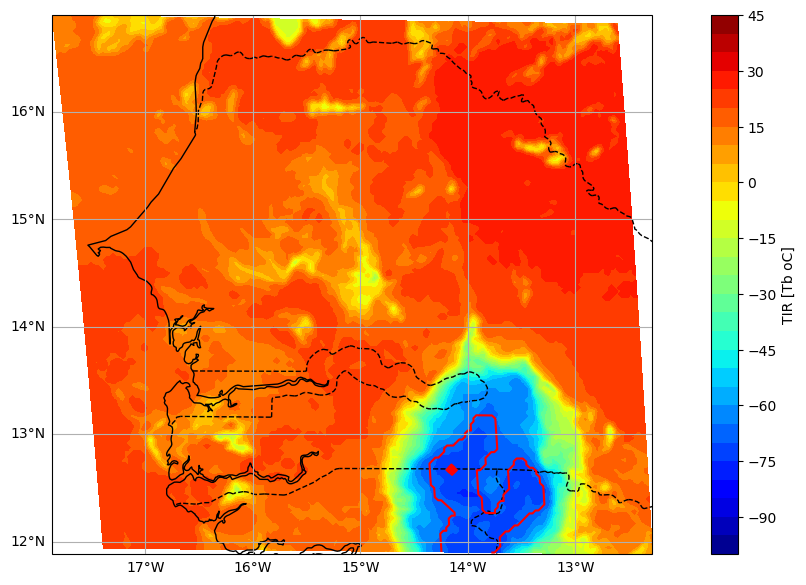

In [10]:
day = 96*19
f=plt.figure(figsize=(15,7))  # this opens a plot window
ax = f.add_subplot(111, projection=ccrs.PlateCarree())  # this opens a new plot axis
draw_map(ax, tir[day,:,:], lon, lat, levels=np.arange(-100,50,5), cbar_label='TIR [Tb oC]', cmap='jet')
#ax.contour(lon, lat, cores[day,:,:], levels=[-5,1,50], colors='r')
ax.contour(lon, lat, cores[day,:,:], colors='r')

#

In [11]:
# input data- cores_t_0: 
# starting at 
num_frames= 1#8  # previous 2 hours of images to predict 1 hr later
t0= 0#1   #*4 # # 15 min  later (4 frames at 15 min)
a= 45
b= 48
#cores_t_minus_xhr = cores[0:-2*t0, a:,b:]
#cores_t_0 = cores[t0:-t0, a:,b:]
#tir_t_minus_xhr = tir[0:-2*t0,a:,b:]
#tir_t_0 = tir[t0:-t0, a:,b:]
cores_t_0 = cores[0:-num_frames-t0, :-a,b:]
tir_t_0 = tir[0:-num_frames-t0, :-a,b:]


#target data
cores_t_plus_xhr = cores[t0+num_frames:,:-a,b:]
ind = np.where(cores_t_plus_xhr>0)
cores_t_plus_xhr[ind] = 1
ind_not = np.where(cores_t_plus_xhr<=0)
cores_t_plus_xhr[ind_not] = 0
print(np.unique(cores_t_plus_xhr))



[0. 1.]


In [12]:
#cores_t_plus_xhr = cores[t0+num_frames:, a:,b:]
#ind = np.where(cores_t_plus_xhr>0)
#print(np.unique(cores[:t0+num_frames,:-a,b:]))
#print(np.unique(cores[t0+num_frames:,:-a,b:]))
#print(np.unique(cores_t_plus_xhr))
#cores_t_plus_xhr.sum()
#print(cores_t_plus_xhr[ind])
#print(ind)
print(cores_t_0.shape)
print(cores_t_plus_xhr.shape)


(17663, 128, 128)
(17663, 128, 128)


/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


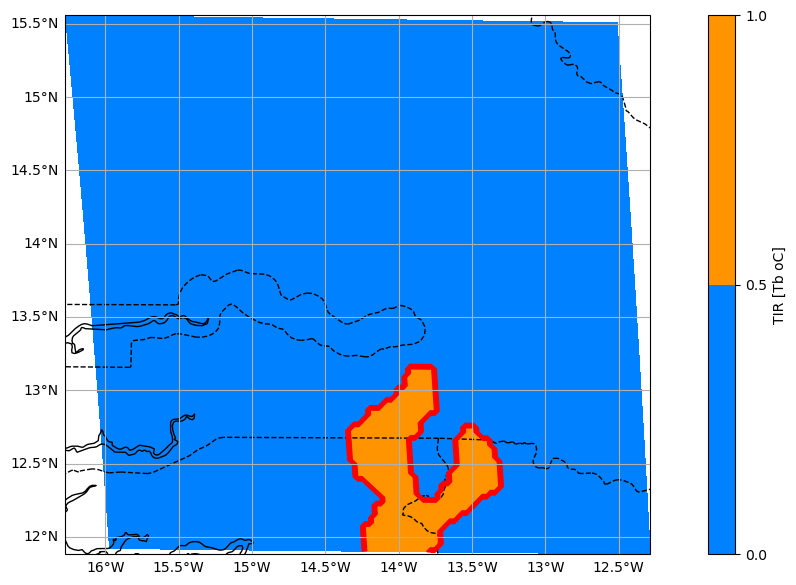

In [13]:
day = 96*19  #t0+num_frames+63  #96*19-36
f=plt.figure(figsize=(15,7))  # this opens a plot window
ax = f.add_subplot(111, projection=ccrs.PlateCarree())  # this opens a new plot axis
draw_map(ax, cores_t_plus_xhr[day- (t0+num_frames),:,:], lon[:-a,b:], lat[:-a,b:], levels=[0,0.5,1], cbar_label='TIR [Tb oC]', cmap='jet')
ax.contour(lon[:-a,b:], lat[:-a,b:], cores[day,:-a,b:], colors='r')
#draw_map(ax, cores[day,:-a,b:], lon[:-a,b:], lat[:-a,b:], levels=[0,0.5,1], cbar_label='TIR [Tb oC]', cmap='jet')
#draw_map(ax, cores[day,:-a,b:], lon[:-a,b:], lat[:-a,b:], cbar_label='TIR [Tb oC]', cmap='jet')

#

In [14]:
# save variables 
#with open('pkl_files/WA_subdomain_cores_2hr_back.pkl', 'wb') as file: 
  #        pickle.dump([cores_t_0,tir_t_0,cores_t_plus_xhr], file) 
        

In [15]:
# open a file, where you stored the pickled data
#file = open('WA_subdomain_cores.pkl', 'rb')
#data = pickle.load(file)
#cores_t_0= data[0]
#tir_t_0= data[1]
#cores_t_plus_xhr= data[2]

In [16]:
# Define input shape
#num_frames= 24  # 6 hours
image_height= len(cores_t_plus_xhr[1,:,1]) #lat
image_width= len(cores_t_plus_xhr[1,1,:]) #lon
num_channels= 1 #  core at t0-       tir at t0-x, t0, , cores
#input_shape = (image_height, image_width, num_channels)
#input_shape = (num_frames, image_height, image_width, num_channels)
# Sample data (you should replace this with your own dataset)
#num_samples = len(cores_t_plus_xhr[0,0,:])
#sequence_length = 5



In [17]:
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, image_height,image_width, num_channels))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.ConvLSTM2D(
    filters=8, #64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=8,#64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=8,#64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),
)


In [18]:
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 128, 128,   0         
                             1)]                                 
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, None, 128, 128, 8  7232      
                             )                                   
                                                                 
 batch_normalization (BatchN  (None, None, 128, 128, 8  32       
 ormalization)               )                                   
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, None, 128, 128, 8  4640      
                             )                                   
                                                                 
 batch_normalization_1 (Batc  (None, None, 128, 128, 8  32   

In [19]:
num_frames= 8   #24  # hours
batch_size= int(len(cores_t_0[:,0,0])/num_frames)  # days 720 - 96 one day
val_samples= 50
x_train= np.zeros((batch_size-val_samples,num_frames,image_height,image_width, num_channels))
y_train= np.zeros((batch_size-val_samples,num_frames,image_height,image_width, num_channels))
x_val= np.zeros((val_samples,num_frames,image_height,image_width, num_channels))
y_val= np.zeros((val_samples,num_frames,image_height,image_width, num_channels))
                   
    
for i in range(0,batch_size-val_samples,1):  
    x_train[i,:,:,:,0]= cores_t_0[i*num_frames:(i+1)*num_frames,:,:]
    y_train[i,:,:,:,0]= cores_t_plus_xhr[i*num_frames:(i+1)*num_frames,:,:]
    
    
val_ind= (i+1)*num_frames
    
for i in range(0,val_samples,1):  
    x_val[i,:,:,:,0]= cores_t_0[i*num_frames+val_ind:(i+1)*num_frames+val_ind,:,:]
    y_val[i,:,:,:,0] = cores_t_plus_xhr[i*num_frames+val_ind:(i+1)*num_frames+val_ind,:,:]

           
# normalize input data        
x_train = x_train/np.max(x_train)
x_val = x_val/np.max(x_train)


In [20]:
print(x_train.shape)
print(x_val.shape)
#batch_size-val_samples
#batch_size

(2157, 8, 128, 128, 1)
(50, 8, 128, 128, 1)


In [21]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 2 # 20
batch_size = 8 #50# batch_size#24

# Fit the model to the training data.
model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr],
)

2023-11-24 15:16:20.266344: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1130889216 exceeds 10% of free system memory.


Epoch 1/2


2023-11-24 15:16:20.903163: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1130889216 exceeds 10% of free system memory.


270/270 [==============================] - 638s 2s/step - loss: 0.0713 - val_loss: 0.0775 - lr: 0.0010
Epoch 2/2
270/270 [==============================] - 633s 2s/step - loss: 0.0128 - val_loss: 0.0131 - lr: 0.0010


In [22]:
#example = x_val[np.random.choice(range(len(x_val)), size=1)[0]]
#print(example.shape)
#with open('WA_subdomain_trained_model_2hr_back_15min_forward.pkl', 'wb') as file: 
 #   pickle.dump(model, file) 
        

In [23]:
#print(x_val.shape)
#print(predicted_frame.shape)
#print(np.where(all_frames>0.35))

In [74]:
# Select a random example from the validation dataset.
# example = val_dataset[np.random.choice(range(len(val_dataset)), size=1)[0]]
# using x_val for now 
#all_frames=np.zeros((50,image_height,image_width, num_channels))

#for b in range(0,51,1):
batch_number = 700 #b #50
frames = x_train[batch_number,0:4,:,:,:] # 
original_frames = x_train[batch_number,4:,:,:,:] # 
#print(frames.shape)
#print(original_frames.shape)
#original_frames = y_val[batch_number,5:,:,:,:] # 
#print(frames.shape)

# Predict a new set of 4 frames.
for _ in range(4):
    # Extract the model's prediction and post-process it.
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    # Extend the set of prediction frames.
    frames = np.concatenate((frames, predicted_frame), axis=0)
    #all_frames = np.concatenate((all_frames, predicted_frame), axis=0)


1/1 [==============================] - 0s 41ms/step


In [75]:
print(frames.shape)
print(original_frames.shape)
#print(new_prediction.shape)
#print(lon[:-a,b:].shape)
#print(lat[:-a,b:].shape)
#ind = np.where(frames[24:,:,:,0]>0.25)
#print((ind))

(8, 128, 128, 1)
(4, 128, 128, 1)


/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


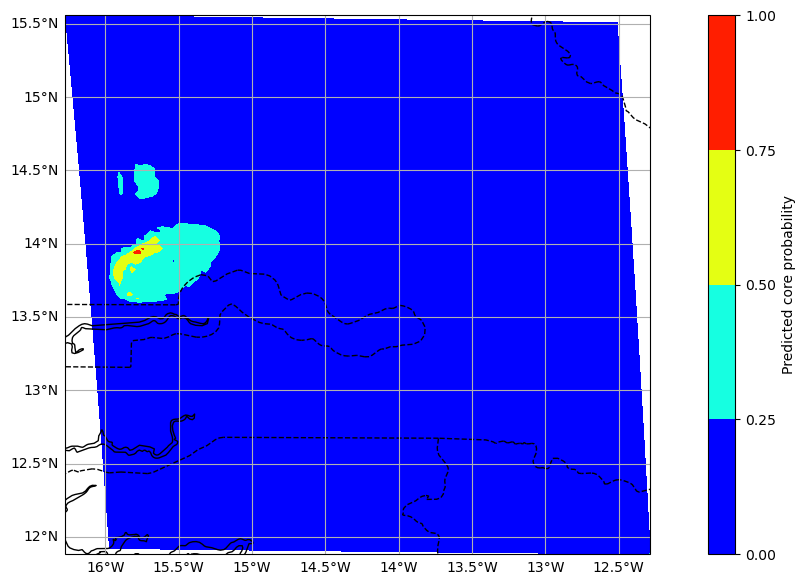

In [76]:
day = 4 #96*19-36
f=plt.figure(figsize=(15,7)) 
ax = f.add_subplot(111, projection=ccrs.PlateCarree()) 
draw_map(ax, np.squeeze(frames[day,:,:,0]), lon[:-a,b:], lat[:-a,b:],levels=[0,0.25,0.5,0.75,1], cbar_label='Predicted core probability', cmap='jet')

#

In [1]:
#day = 23 #96*19-36
f=plt.figure(figsize=(15,7)) 
ax = f.add_subplot(111, projection=ccrs.PlateCarree()) 
draw_map(ax, np.squeeze(original_frames[0,:,:,0]), lon[:-a,b:], lat[:-a,b:],levels=[0,0.5,1], cbar_label='Actual core', cmap='jet')


NameError: name 'plt' is not defined

/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility

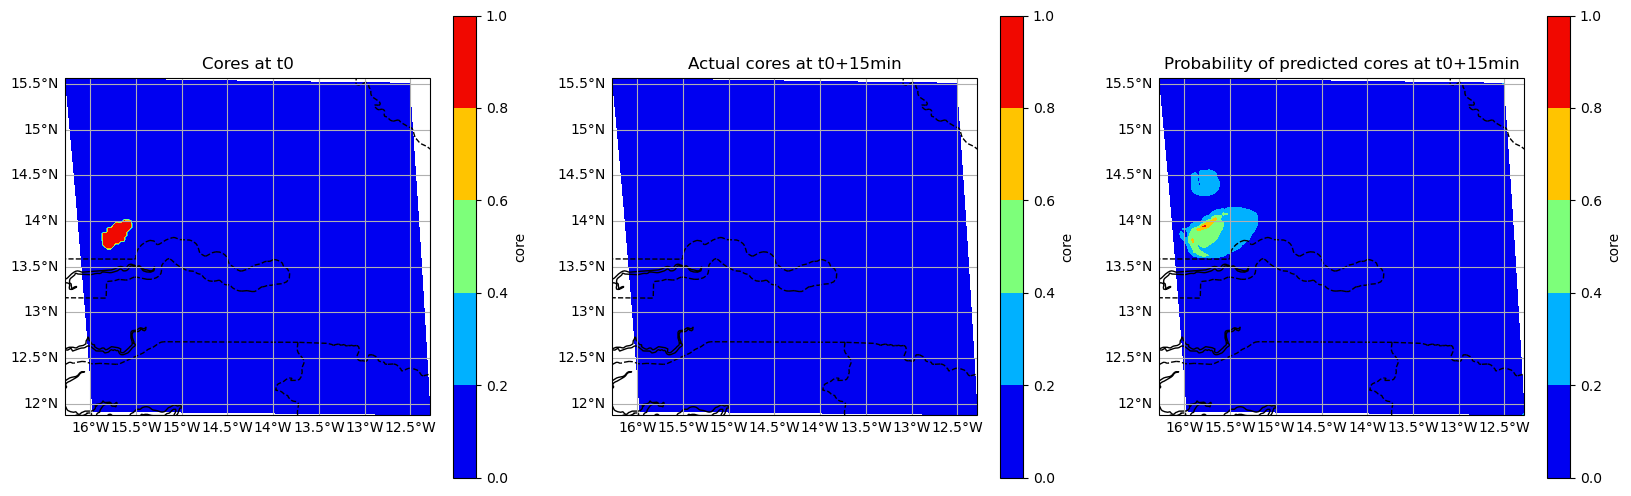

In [78]:
day = 3
data = np.zeros((3,image_height,image_width))
#data[0] = np.squeeze(frames[day-4*t0,:,:,0])
data[0] = np.squeeze(frames[day,:,:,0])
data[1] = np.squeeze(original_frames[0,:,:,0])
data[2] = np.squeeze(frames[day+1,:,:,0])
#titles = ['Cores at t0-1hr', 'Cores at t0', 'Probability of cores at t0+1hr']
titles = ['Cores at t0', 'Actual cores at t0+15min', 'Probability of predicted cores at t0+15min']
levels_custom=[[0, 0.2, 0.4, 0.6, 0.8,1],[0, 0.2, 0.4, 0.6, 0.8,1],[0, 0.2, 0.3,0.325,0.35,0.4,0.5,0.6]]#[0, 0.1, 0.2, 0.3,0.4]]

fig, axes = plt.subplots(1, 3, figsize=(20, 6),
                         subplot_kw={'projection':ccrs.PlateCarree()})

i=0
for ax in axes:
    m= ax.contourf(lon[:-a,b:], lat[:-a,b:], data[i], transform=ccrs.PlateCarree(), levels=levels_custom[0],cmap='jet')  # this is the actual plot
# ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], cmap=contour['cmap'] )
    ax.coastlines()   ## adds coastlines
    # Gridlines
    xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
    xl.xlabels_top = False   ## labels off
    xl.ylabels_right = False
    ax.set_title(titles[i])
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    cbar = plt.colorbar(m)  # adds colorbar
    cbar.set_label('core')
    i=i+1
 
#plt.show()

In [79]:
def plot_maps(ax, lon, lat, data, title,levels_custom):
    m=ax.contourf(lon, lat, data, transform=ccrs.PlateCarree(), levels=levels_custom,cmap='jet')  # this is the actual plot
    ax.coastlines()   ## adds coastlines
    xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
    xl.xlabels_top = False   ## labels off
    xl.ylabels_right = False
    ax.set_title(title)
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    #cbar = plt.colorbar(m)  # adds colorbar
    #cbar.set_label('core')


In [80]:
def plot_maps_colorbar(ax, lon, lat, data, title,levels_custom):
    m=ax.contourf(lon, lat, data, transform=ccrs.PlateCarree(), levels=levels_custom,cmap='jet')  # this is the actual plot
    ax.coastlines()   ## adds coastlines
    xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
    xl.xlabels_top = False   ## labels off
    xl.ylabels_right = False
    ax.set_title(title)
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    cbar = plt.colorbar(m)  # adds colorbar
    cbar.set_label('core')


/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility

Predicting core at 15min


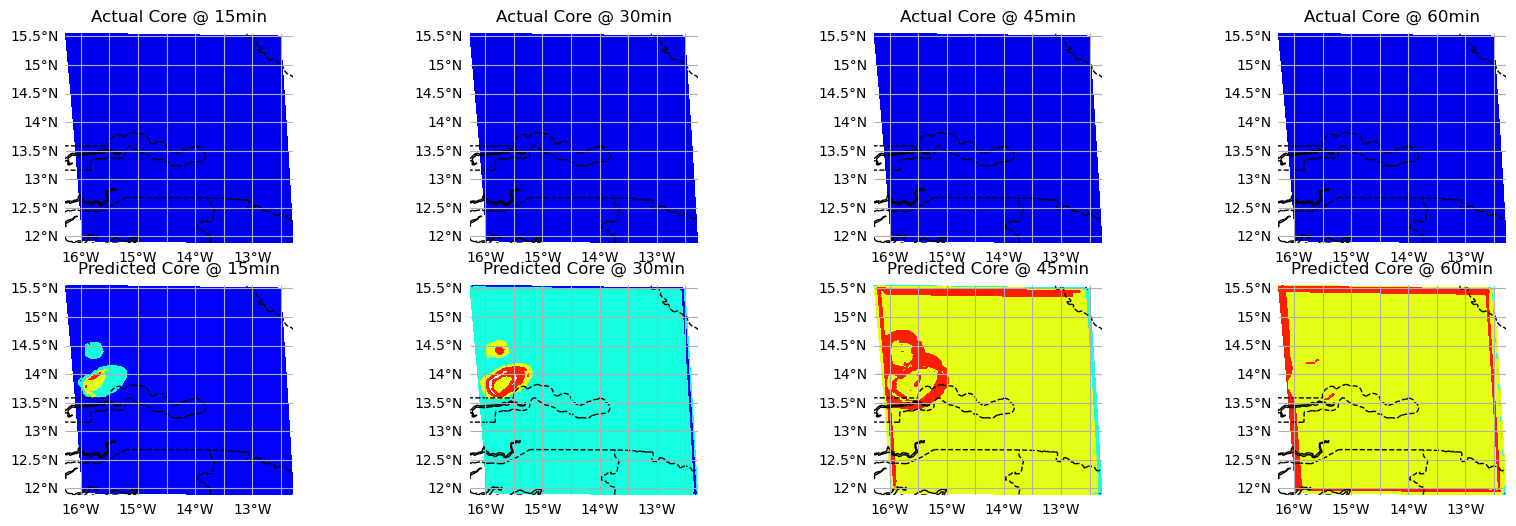

In [81]:
day = 4
data = np.zeros((day,image_height,image_width))
for x in range(0,4,1):
    data[x] = np.squeeze(frames[day+x,:,:,0])
    
    
levels_custom=[[0, 0.2, 0.4, 0.6, 0.8,1],np.arange(0,1,0.2)]#[0, 0.1, 0.2, 0.3,0.4]]
    
fig, axes = plt.subplots(2, 4, figsize=(20, 6),
                         subplot_kw={'projection':ccrs.PlateCarree()})

for idx, ax in enumerate(axes[0]):
    plot_maps(ax, lon[:-a,b:], lat[:-a,b:], np.squeeze(original_frames[idx,:,:,0]),  title=None ,levels_custom= levels_custom[0])
    ax.set_title(f"Actual Core @ {idx*15 + 15}min")
    ax.axis("off")

for idx, ax in enumerate(axes[1]):
    plot_maps(ax, lon[:-a,b:], lat[:-a,b:], data[idx,:,:],  title=None ,levels_custom= levels_custom[1])
    ax.set_title(f"Predicted Core @ {idx*15 + 15}min")
    ax.axis("off")

# Print information and display the figure.
print('Predicting core at 15min')
plt.show()